In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
import torch.distributions.constraints as constraints

In [3]:
%matplotlib inline

In [4]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [ ]:
"Other Architectures that were tried"

"""class NN(nn.Module):
    
    def __init__(self):
        super(NN, self).__init__()
        
        # 1 input image channel, 32 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1,32, 3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.dropout=nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.dropout1=nn.Dropout(0.5)
        self.out = nn.Linear(128, 10)
        #self.out = nn.Linear(84, 10)
   
       # self.conv2 = nn.Conv2d(, 16, 5)
        # an affine operation: y = Wx + b
        #self.fc1 = nn.Linear(16 * 5 * 5, 10)
        #self.fc1 = nn.Linear(16*14*14, 1024)
        #self.out = nn.Linear(1024, 10)
       # self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #output = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        output=F.relu(self.conv1(x))
        output = F.max_pool2d(F.relu(self.conv2(output)), (2, 2))
        output=self.dropout(output)
        
        # If the size is a square you can only specify a single number
        #output = F.max_pool2d(F.relu(self.conv2(output)), 2)
        output = output.view(-1, self.num_flat_features(output))
        output = F.relu(self.fc1(output))
        output=self.dropout(output)
        #output = F.relu(self.fc2(output))
        #output = F.relu(output)
        #output = F.softmax(self.out(output),dim=1)
        output =self.out(output)
        return output
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
       # x = self.fc3(x)
       # return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
                             # 0 is the batch dimensions
        num_features = 1
        for s in size:
            num_features *= s
        #print(size)
        #rint(x.size())
        #print(num_features)
        return num_features"""


In [ ]:
"To Load MNIST DATA uncomment this cell and comment out other data set cells"


"""train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=1, shuffle=True)"""

In [ ]:
"To Load CIFAR10 uncomment this cell and comment out other data set cells "

"""transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')"""

In [6]:
"Load Fashion MNIST"

train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('fashionmnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('fashionmnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [7]:
#Use the No. of Neurons by commenting out the one you want to use
#net = NN(28*28, 512, 10)
net = NN(28*28, 1024, 10)
#net = NN(28*28, 2048, 10)

In [8]:
import pyro
from pyro.distributions import Normal, Categorical,Beta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [9]:
log_softmax = nn.LogSoftmax(dim=1)

In [10]:
#Gaussian Distribution ~N(0,1)

def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [ ]:
"Used for Beta Distribution"

"""def model(x_data, y_data):
    
    fc1w_prior = Beta(torch.ones_like(net.fc1.weight), torch.ones_like(net.fc1.weight))
    fc1b_prior = Beta(torch.ones_like(net.fc1.bias), torch.ones_like(net.fc1.bias))
    
    outw_prior = Beta(torch.ones_like(net.out.weight), torch.ones_like(net.out.weight))
    outb_prior =Beta(torch.ones_like(net.out.bias), torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)"""

In [ ]:
#Model tried For Deeper Architectures
"""def model(x_data, y_data):
    
    conv1w_prior = Normal(loc=torch.zeros_like(net.conv1.weight), scale=torch.ones_like(net.conv1.weight))
    conv1b_prior = Normal(loc=torch.zeros_like(net.conv1.bias), scale=torch.ones_like(net.conv1.bias))
    
    conv2w_prior = Normal(loc=torch.zeros_like(net.conv2.weight), scale=torch.ones_like(net.conv2.weight))
    conv2b_prior = Normal(loc=torch.zeros_like(net.conv2.bias), scale=torch.ones_like(net.conv2.bias))
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
   # fc2w_prior = Normal(loc=torch.zeros_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
    #fc2b_prior = Normal(loc=torch.zeros_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
   # priors = {'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior,}
    priors = {'conv1.weight': conv1w_prior, 'conv1.bias': conv1b_prior, 'conv2.weight': conv2w_prior, 'conv2.bias': conv2b_prior,'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior,}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)"""

In [12]:
#Gaussian Distribution ~N(0,1)

softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [ ]:
"Used for Beta Distribution"
"""softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu,constraint=constraints.positive)
    fc1w_sigma_param = pyro.param("fc1w_sigma", fc1w_sigma,constraint=constraints.positive) #Keep the constraints positive for 
    fc1w_prior = Beta(fc1w_mu_param, fc1w_sigma_param)                                      #Beta distribution
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu,constraint=constraints.positive)
    fc1b_sigma_param = pyro.param("fc1b_sigma", fc1b_sigma,constraint=constraints.positive)
    fc1b_prior = Beta(fc1b_mu_param, fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu,constraint=constraints.positive)
    outw_sigma_param = pyro.param("outw_sigma", outw_sigma,constraint=constraints.positive)
    outw_prior = Beta(outw_mu_param, outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu,constraint=constraints.positive)
    outb_sigma_param = pyro.param("outb_sigma", outb_sigma,constraint=constraints.positive)
    outb_prior = Beta(outb_mu_param, outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()"""

In [ ]:
#Guide tried for deeper networks

"""softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    #convolution layer weights
    conv1w_mu = torch.randn_like(net.conv1.weight)
    conv1w_sigma = torch.randn_like(net.conv1.weight)
    conv1w_mu_param = pyro.param("conv1w_mu", conv1w_mu)
    conv1w_sigma_param = softplus(pyro.param("conv1w_sigma", conv1w_sigma))
    conv1w_prior = Normal(loc=conv1w_mu_param, scale=conv1w_sigma_param)
    # First layer bias distribution priors
    conv1b_mu = torch.randn_like(net.conv1.bias)
    conv1b_sigma = torch.randn_like(net.conv1.bias)
    conv1b_mu_param = pyro.param("conv1b_mu", conv1b_mu)
    conv1b_sigma_param = softplus(pyro.param("conv1b_sigma", conv1b_sigma))
    conv1b_prior = Normal(loc=conv1b_mu_param, scale=conv1b_sigma_param)
    
    
     #convolution layer weights
    conv2w_mu = torch.randn_like(net.conv2.weight)
    conv2w_sigma = torch.randn_like(net.conv2.weight)
    conv2w_mu_param = pyro.param("conv2w_mu", conv2w_mu)
    conv2w_sigma_param = softplus(pyro.param("conv2w_sigma", conv2w_sigma))
    conv2w_prior = Normal(loc=conv2w_mu_param, scale=conv2w_sigma_param)
    # First layer bias distribution priors
    conv2b_mu = torch.randn_like(net.conv2.bias)
    conv2b_sigma = torch.randn_like(net.conv2.bias)
    conv2b_mu_param = pyro.param("conv2b_mu", conv2b_mu)
    conv2b_sigma_param = softplus(pyro.param("conv2b_sigma", conv2b_sigma))
    conv2b_prior = Normal(loc=conv2b_mu_param, scale=conv2b_sigma_param)
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
    # First layer weight distribution priors
#   fc2w_sigma = torch.randn_like(net.fc2.weight)
#    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
#    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
#    fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
    # First layer bias distribution priors
#    fc2b_mu = torch.randn_like(net.fc2.bias)
 #   fc2b_sigma = torch.randn_like(net.fc2.bias)
  #  fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
   # fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    #fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
    
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
   
   # priors = {'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    priors = {'conv1.weight': conv1w_prior, 'conv1.bias': conv1b_prior,'conv2.weight': conv2w_prior, 'conv2.bias': conv2b_prior,'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior,}
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()"""

In [14]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [16]:
num_iterations = 7
loss = 0
total_epoch_loss_train=[None]*num_iterations

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train[j]=loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train[j])

Epoch  0  Loss  3189.8591522200823
Epoch  1  Loss  917.5181700662772
Epoch  2  Loss  333.97207261918385
Epoch  3  Loss  163.6020581352552
Epoch  4  Loss  113.51215360169411
Epoch  5  Loss  98.31725832861265
Epoch  6  Loss  94.87273273671468


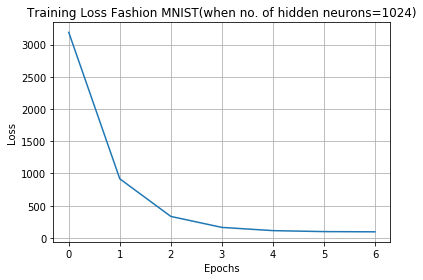

In [33]:
epoch_it = np.arange(0,num_iterations)
#plt.subplot(1,2,1)
plt.plot(epoch_it, total_epoch_loss_train)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Fashion MNIST(when no. of hidden neurons=1024)')

#plt.subplot(1,2,2)
#plt.plot(epoch_it, acc)
#plt.grid()
#plt.xlabel('Epoch')
#plt.ylabel('Training accuracy')
plt.tight_layout()
plt.show()

In [18]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 72 %


In [37]:
#comment this cell when using Cifar10 and #comment 'classes_dict' when using MNIST.
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
classes_dict = {0:"T-shirt",1:"Trouser",2:"PullOver",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle Boot"}


In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
   
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [21]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)


In [38]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",classes_dict[labels[i].item()])
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(classes_dict[j]+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        if(predicted_for_images>0):
            print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
            
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [39]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))


Prediction when network can refuse
Total images:  10000
Skipped:  3342
Accuracy when made predictions: 88 %


In [40]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

Real:  T-shirt


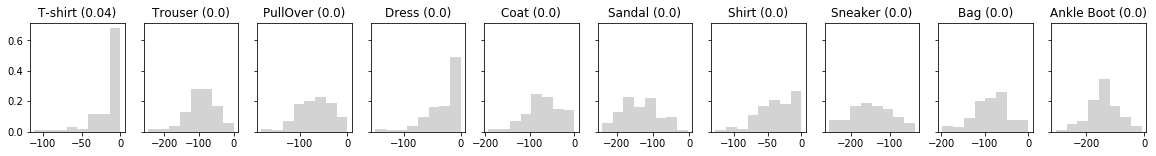

Undecided.


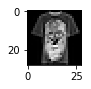

Real:  T-shirt


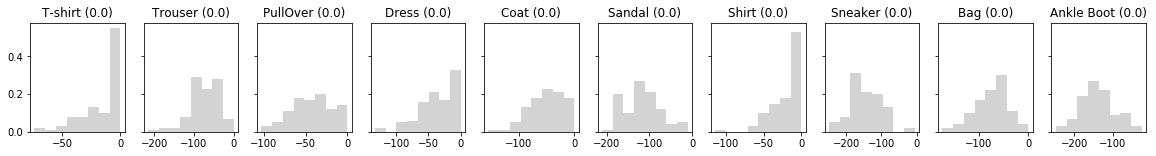

Undecided.


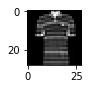

Real:  Shirt


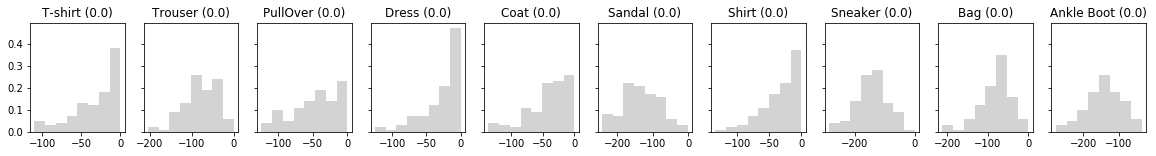

Undecided.


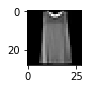

Real:  PullOver


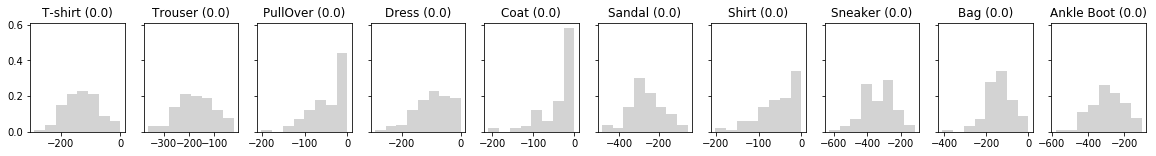

Undecided.


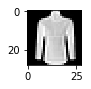

Real:  Bag


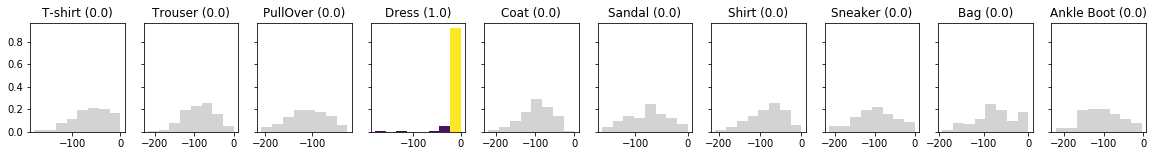

Incorrect :()


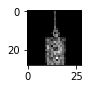

Real:  Shirt


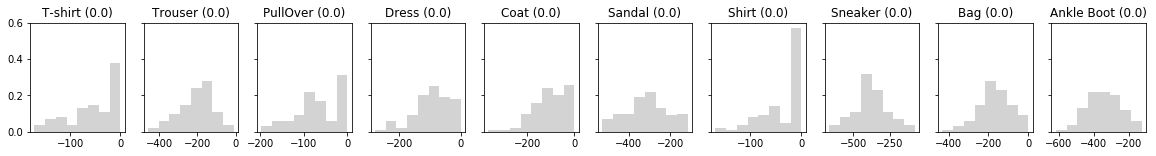

Undecided.


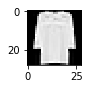

Real:  Sandal


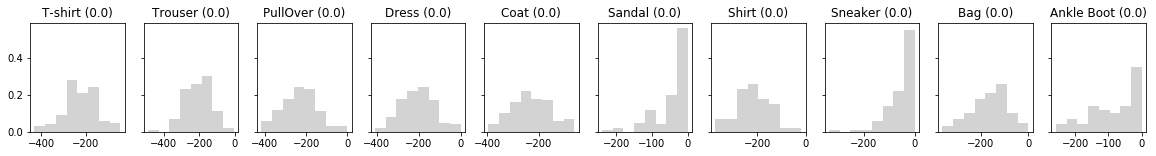

Undecided.


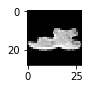

Real:  Trouser


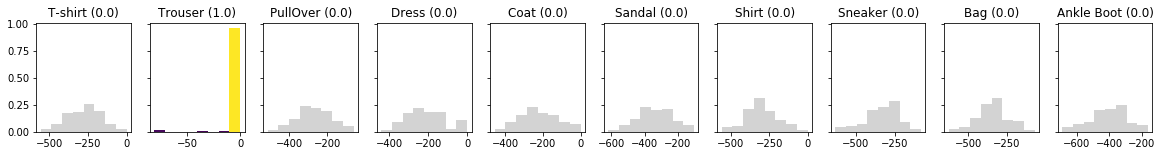

Correct


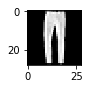

Real:  Ankle Boot


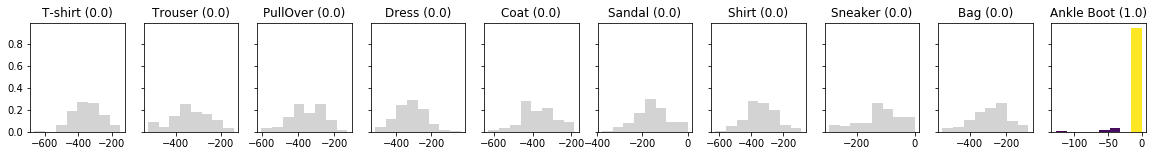

Correct


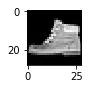

Real:  Shirt


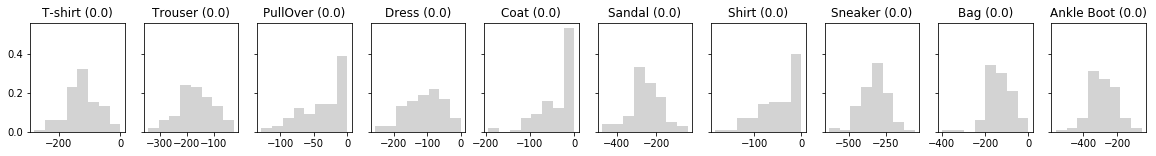

Undecided.


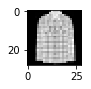

Real:  T-shirt


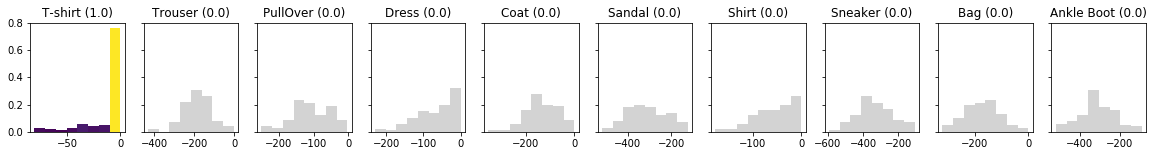

Correct


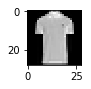

Real:  T-shirt


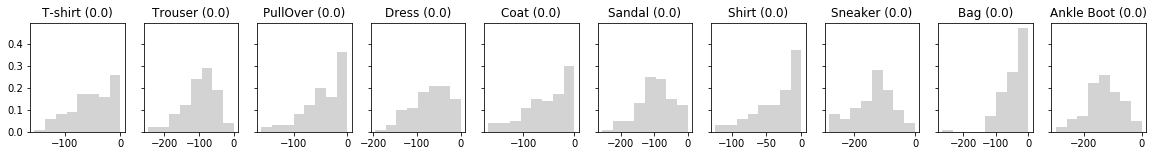

Undecided.


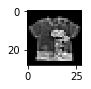

Real:  T-shirt


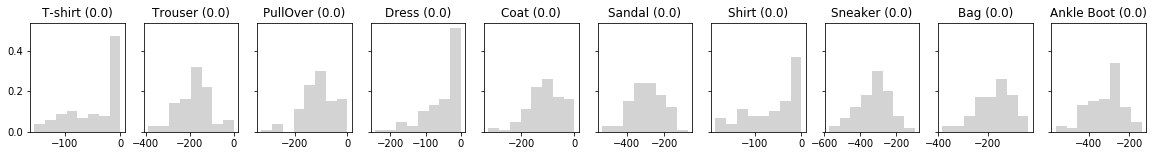

Undecided.


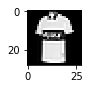

Real:  Ankle Boot


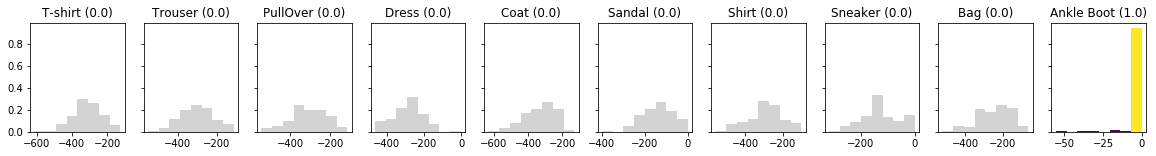

Correct


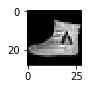

Real:  Ankle Boot


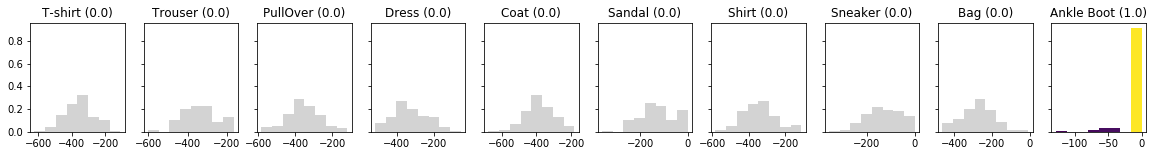

Correct


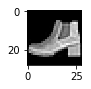

Real:  Shirt


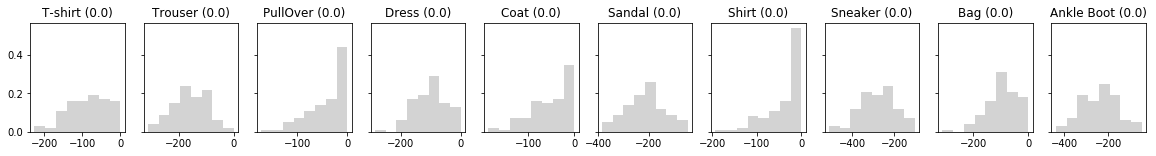

Undecided.


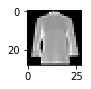

Real:  Sandal


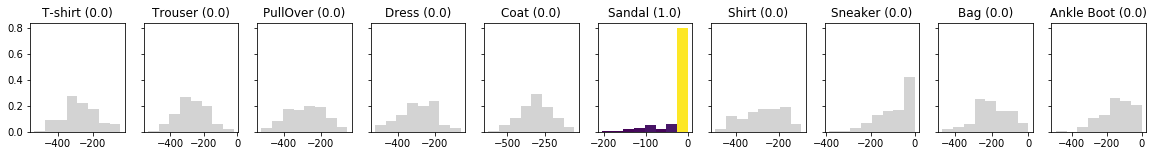

Correct


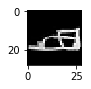

Real:  Dress


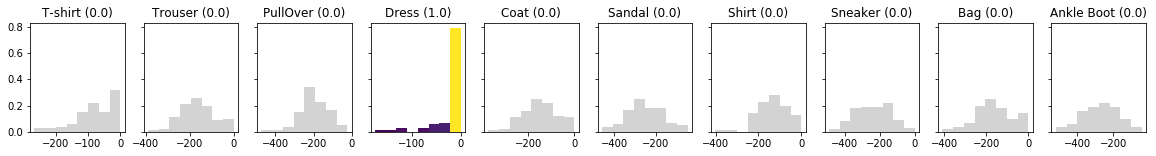

Correct


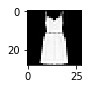

Real:  Ankle Boot


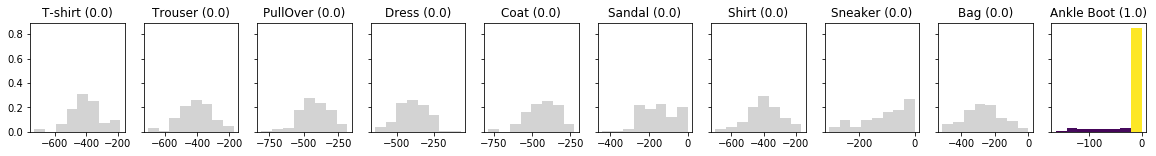

Correct


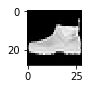

Real:  Trouser


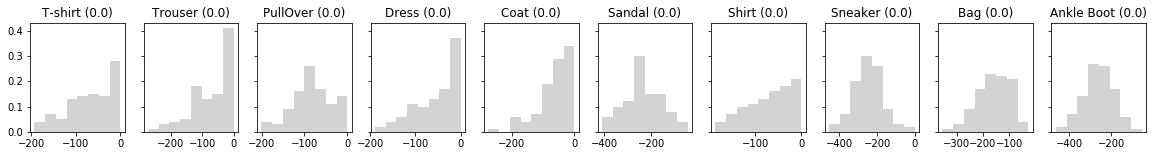

Undecided.


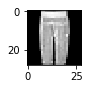

Real:  PullOver


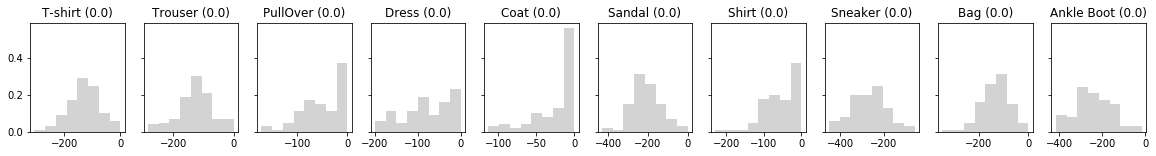

Undecided.


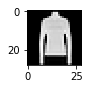

Real:  Coat


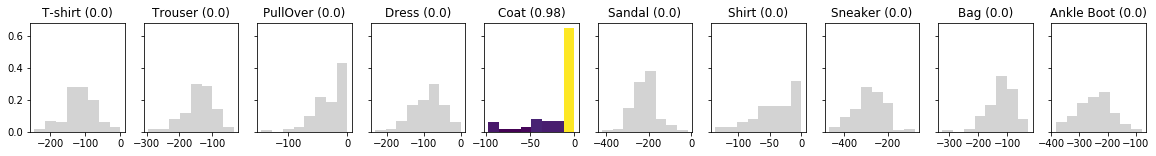

Correct


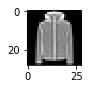

Real:  Coat


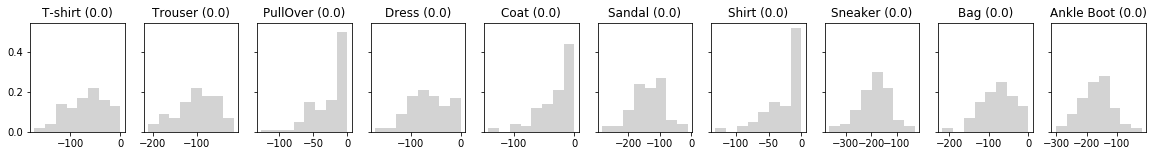

Undecided.


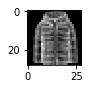

Real:  Trouser


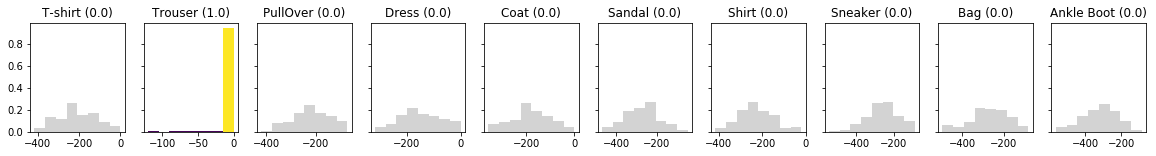

Correct


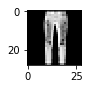

Real:  Sneaker


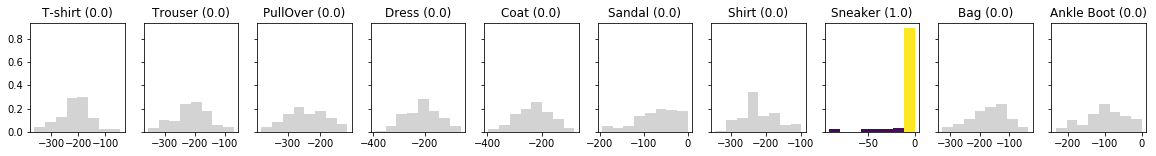

Correct


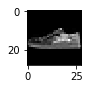

Real:  Bag


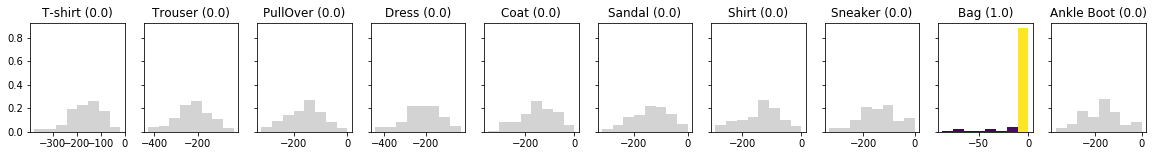

Correct


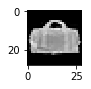

Real:  Bag


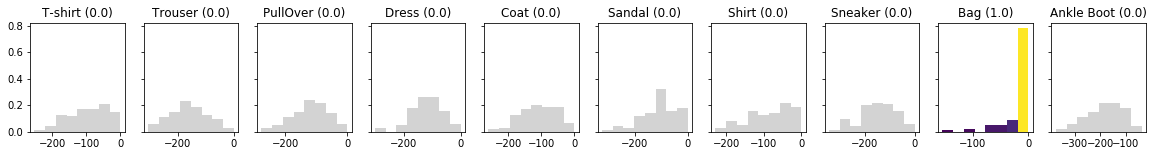

Correct


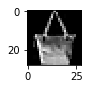

Real:  Sandal


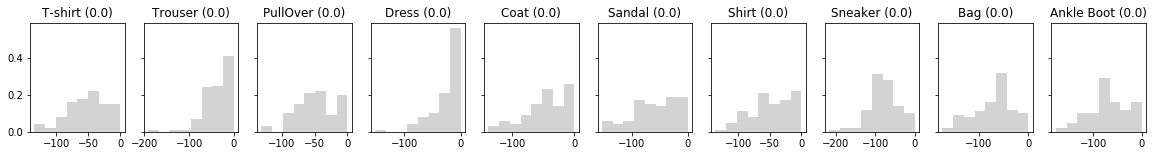

Undecided.


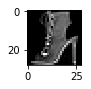

Real:  PullOver


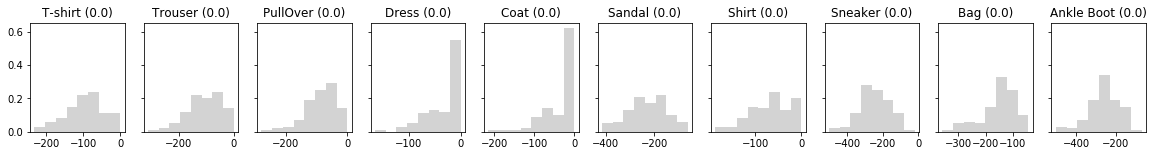

Undecided.


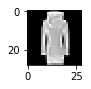

Real:  Bag


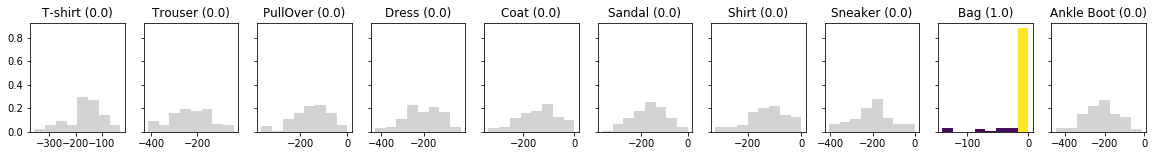

Correct


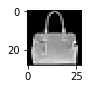

Real:  PullOver


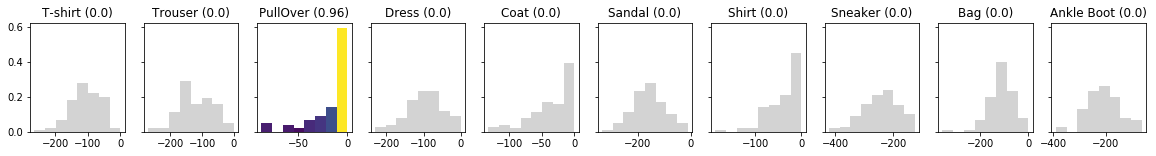

Correct


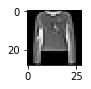

Real:  Dress


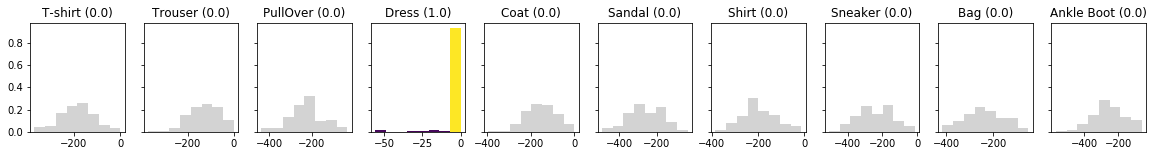

Correct


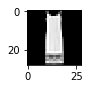

Real:  Ankle Boot


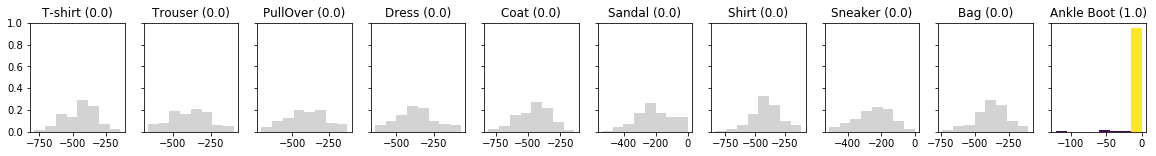

Correct


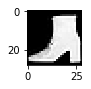

Real:  Sandal


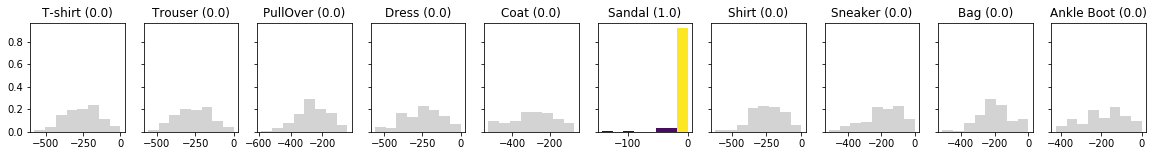

Correct


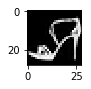

Real:  T-shirt


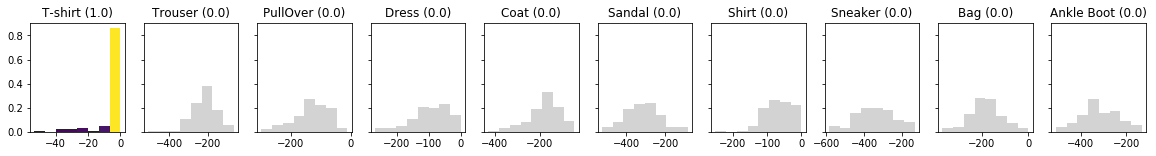

Correct


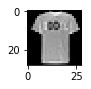

Real:  PullOver


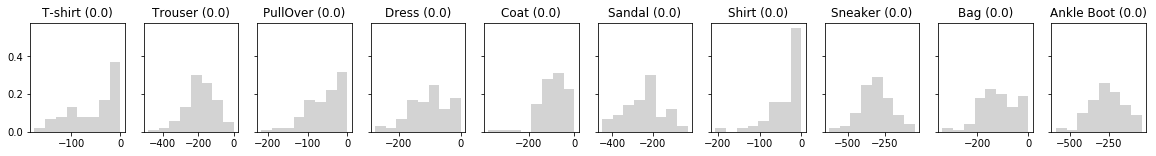

Undecided.


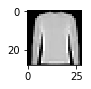

Real:  Sneaker


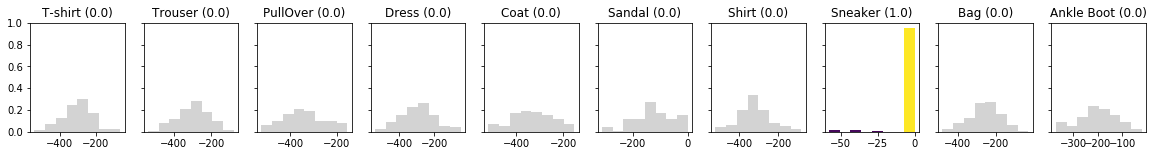

Correct


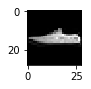

Real:  Coat


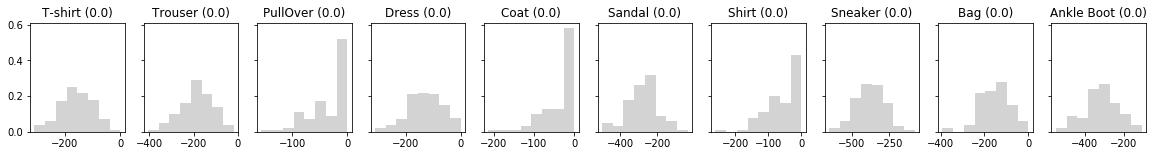

Undecided.


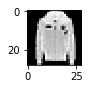

Real:  Bag


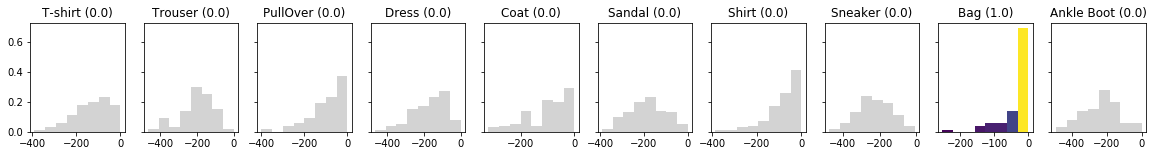

Correct


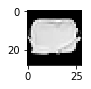

Real:  Sandal


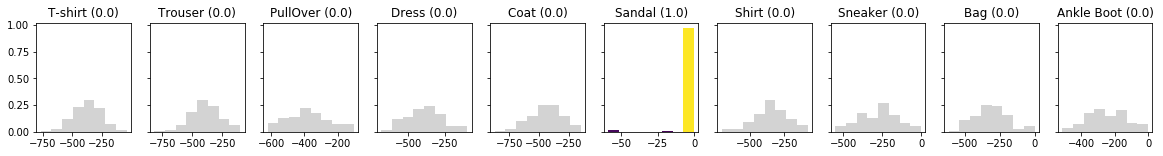

Correct


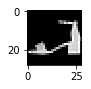

Real:  Coat


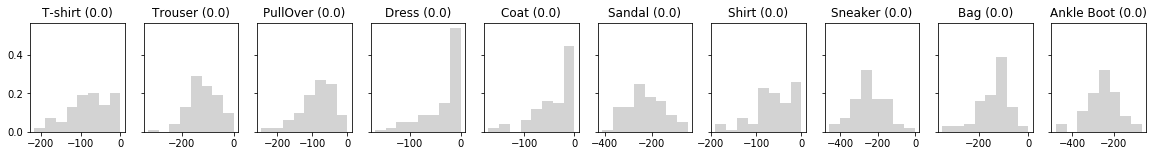

Undecided.


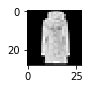

Real:  PullOver


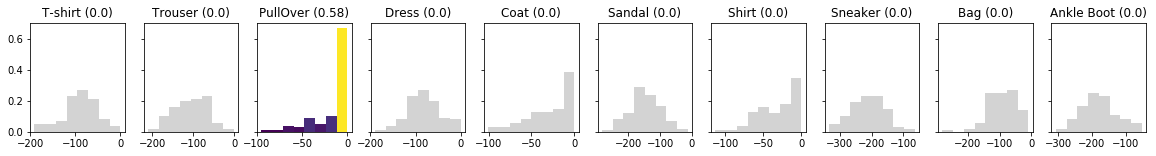

Correct


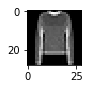

Real:  Coat


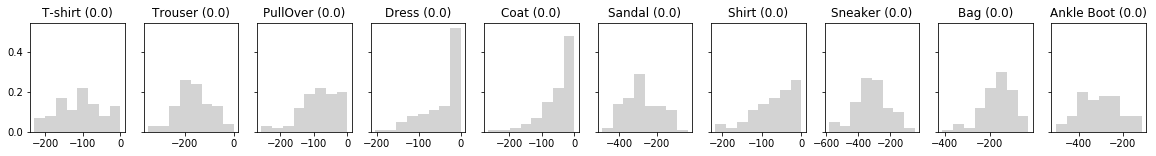

Undecided.


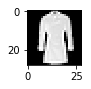

Real:  Dress


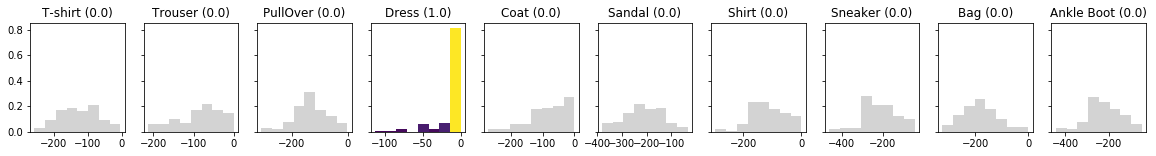

Correct


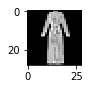

Real:  Dress


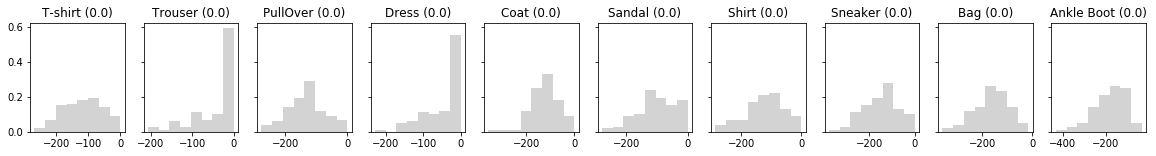

Undecided.


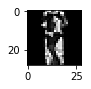

Real:  Trouser


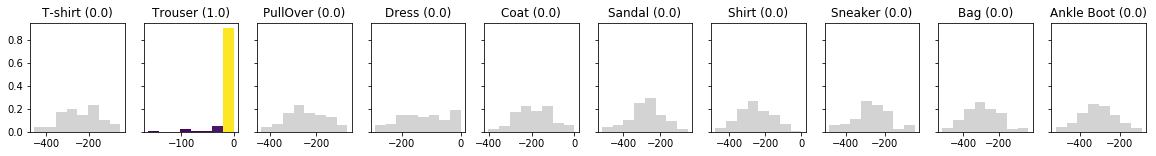

Correct


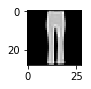

Real:  Sandal


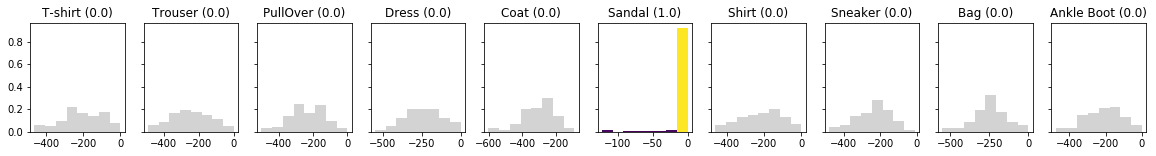

Correct


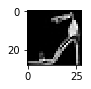

Real:  Sandal


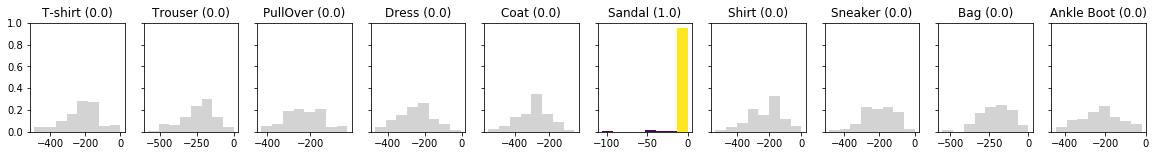

Correct


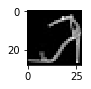

Real:  T-shirt


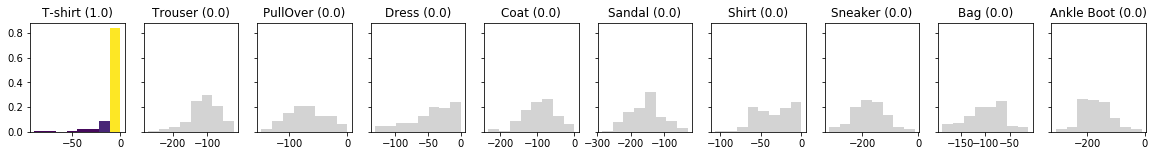

Correct


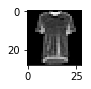

Real:  Sandal


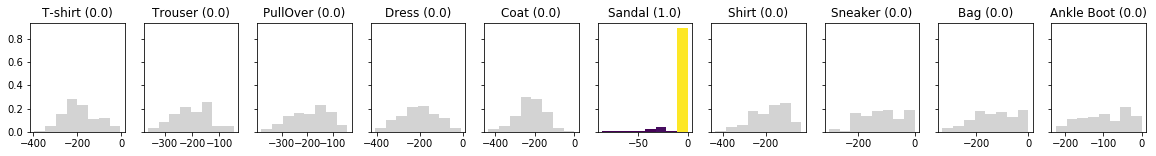

Correct


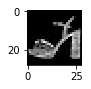

Real:  Sneaker


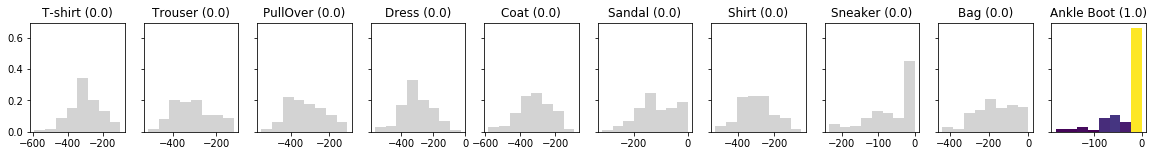

Incorrect :()


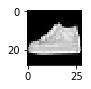

Real:  PullOver


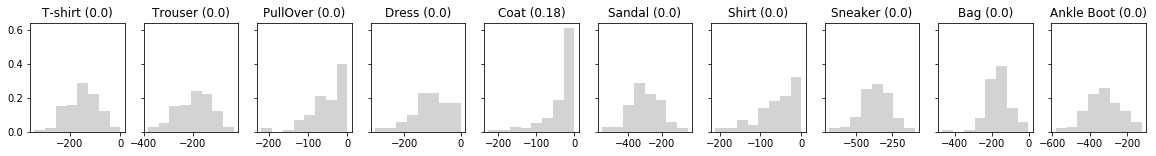

Undecided.


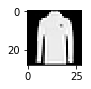

Real:  Dress


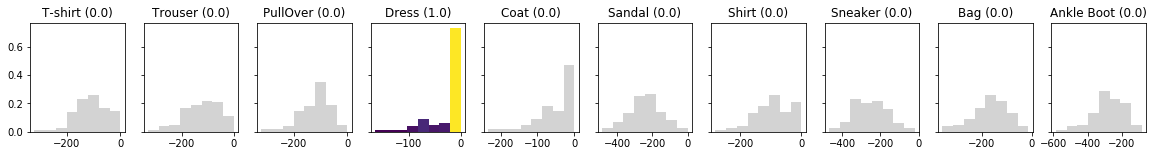

Correct


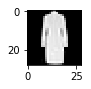

Real:  PullOver


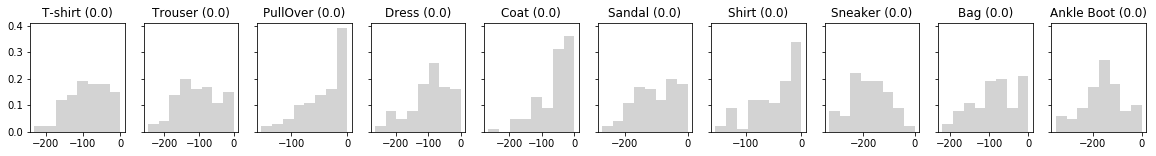

Undecided.


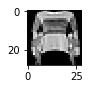

Real:  Sneaker


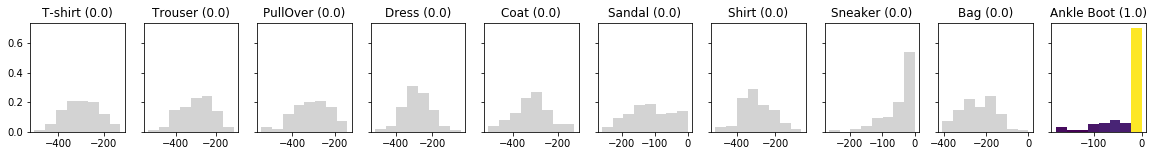

Incorrect :()


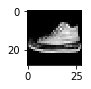

Real:  Sneaker


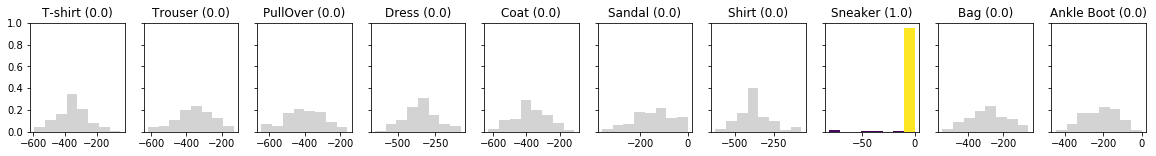

Correct


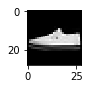

Real:  Dress


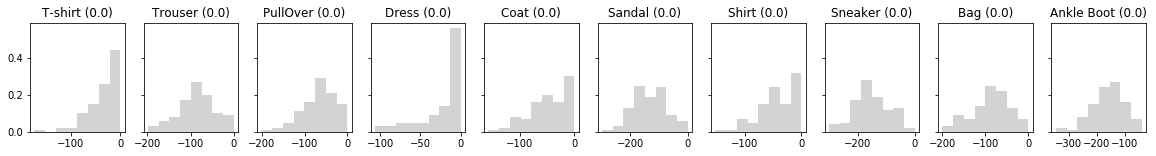

Undecided.


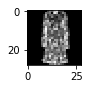

Real:  Trouser


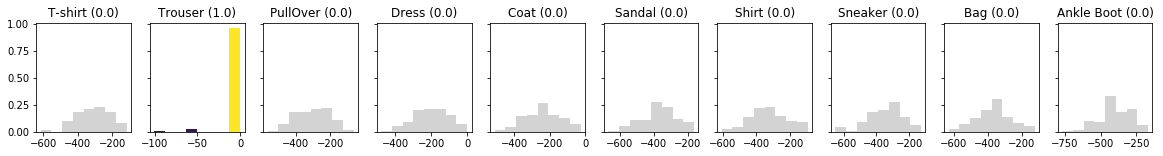

Correct


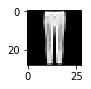

Real:  Bag


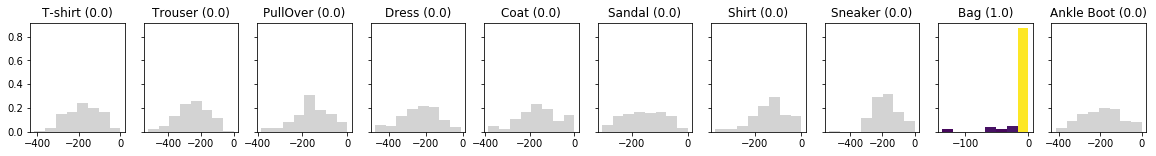

Correct


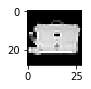

Real:  Trouser


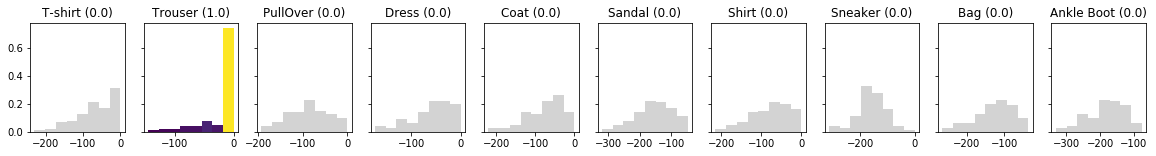

Correct


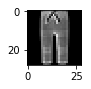

Real:  Trouser


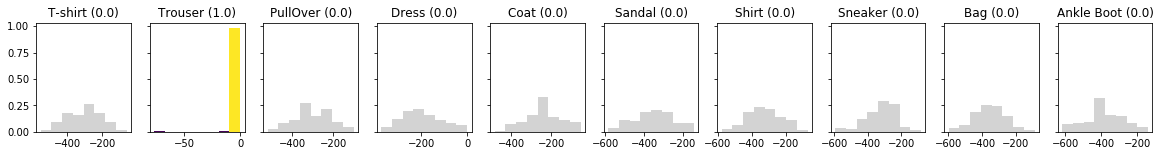

Correct


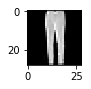

Real:  T-shirt


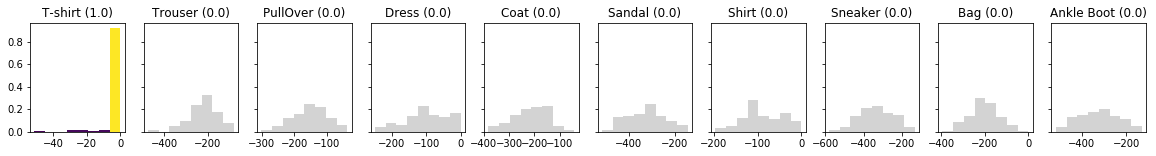

Correct


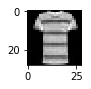

Real:  Sneaker


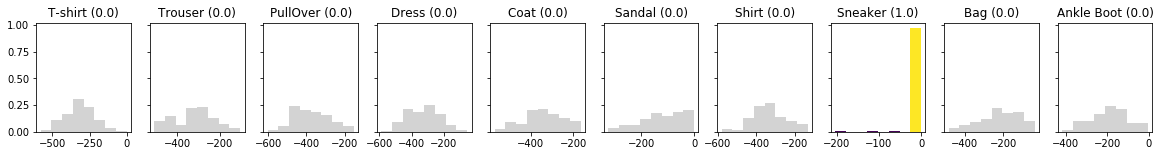

Correct


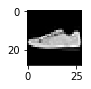

Real:  Dress


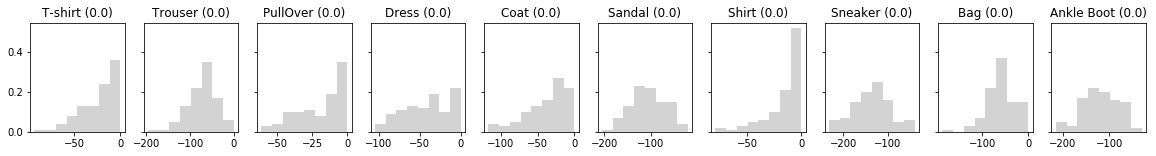

Undecided.


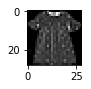

Real:  Dress


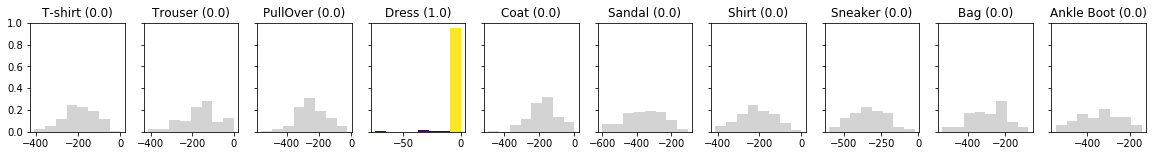

Correct


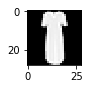

Real:  Dress


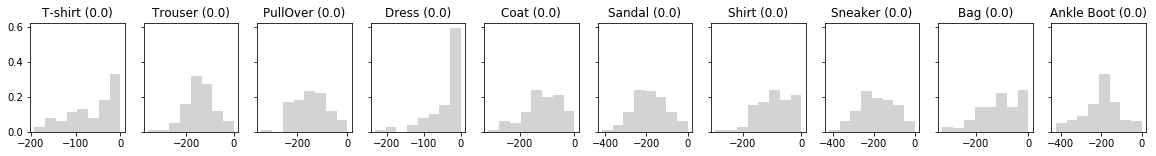

Undecided.


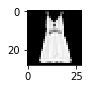

Real:  Dress


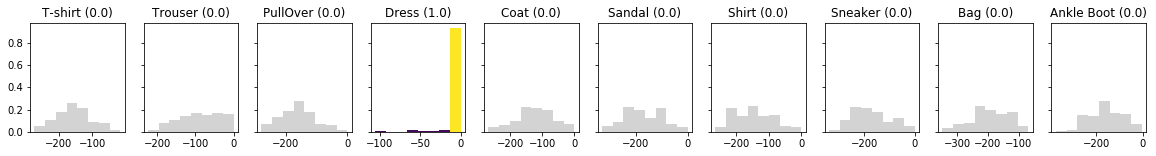

Correct


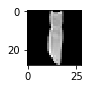

Real:  Dress


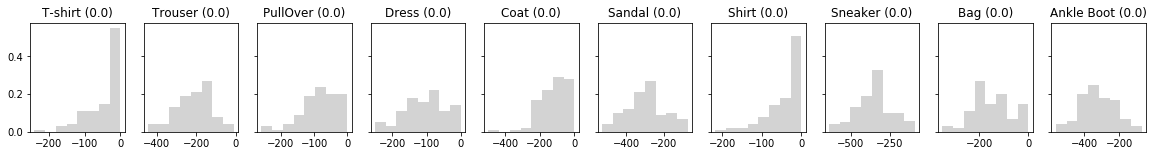

Undecided.


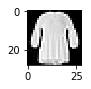

Real:  Dress


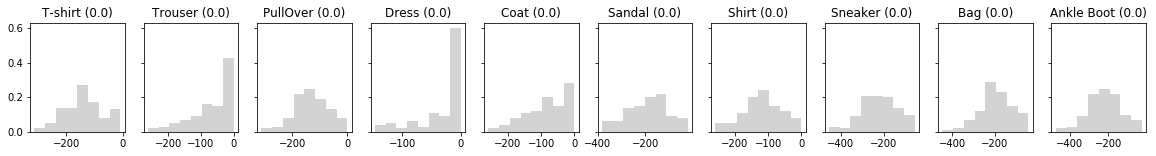

Undecided.


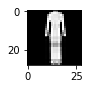

Real:  Ankle Boot


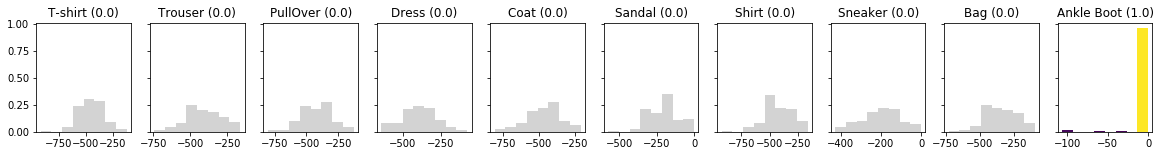

Correct


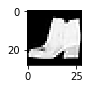

Real:  Shirt


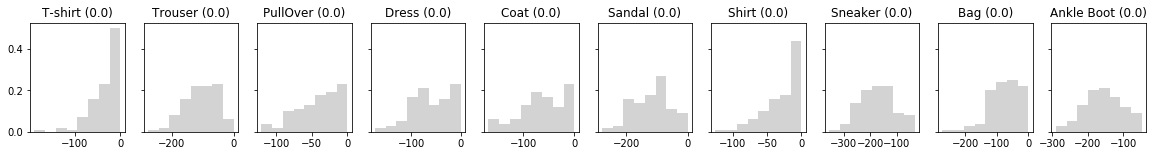

Undecided.


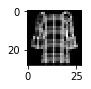

Real:  Sneaker


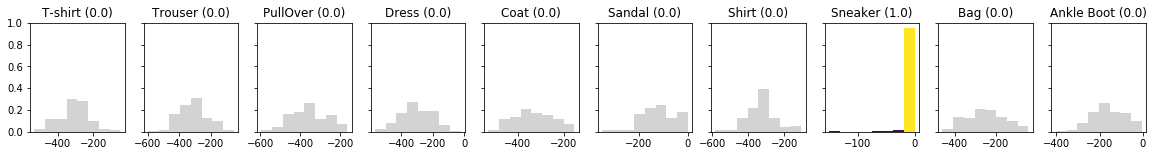

Correct


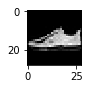

Real:  Sneaker


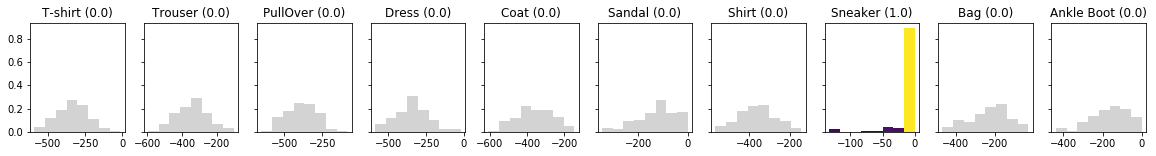

Correct


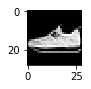

Real:  Ankle Boot


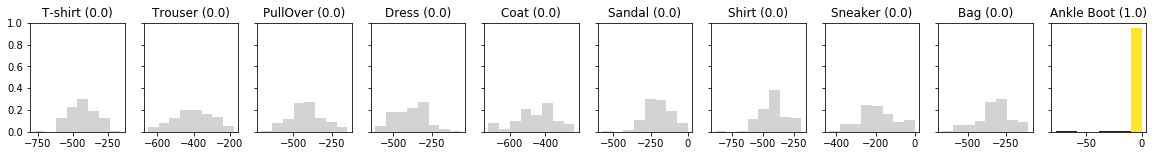

Correct


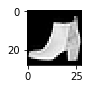

Real:  PullOver


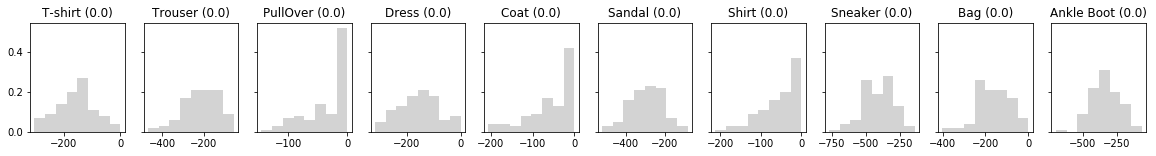

Undecided.


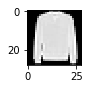

Real:  T-shirt


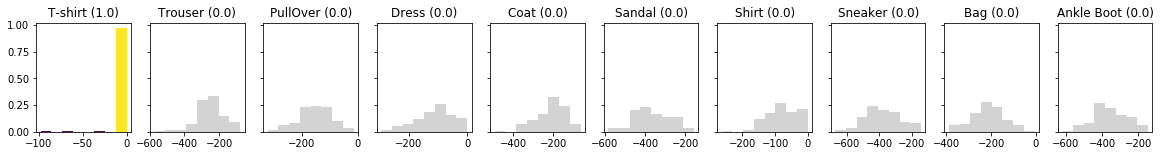

Correct


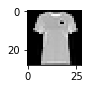

Real:  Sneaker


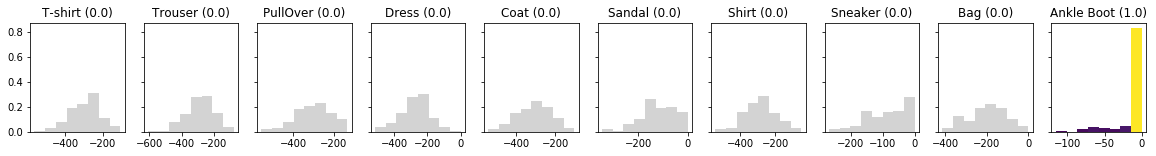

Incorrect :()


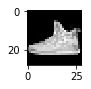

Real:  PullOver


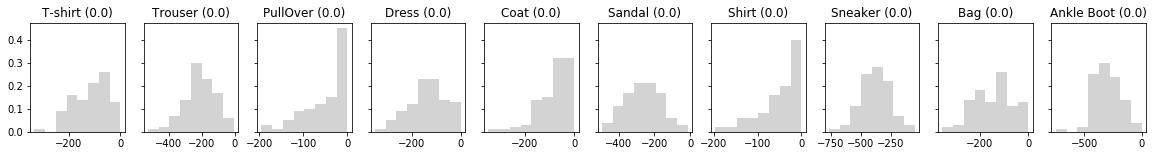

Undecided.


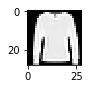

Real:  Sandal


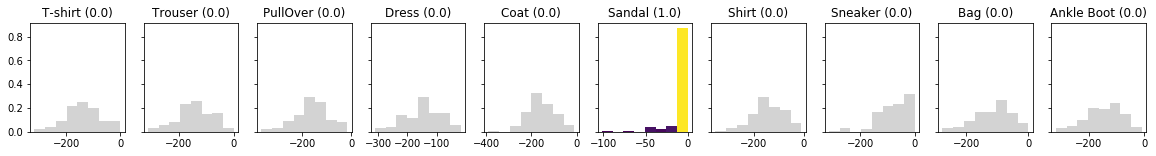

Correct


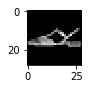

Real:  Bag


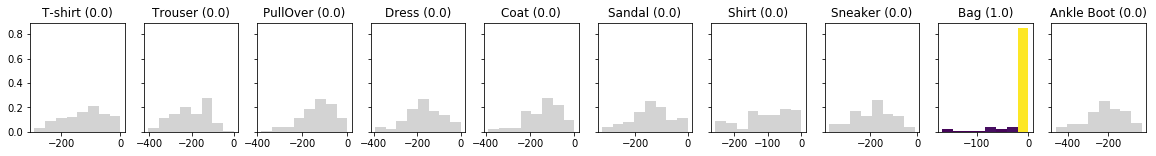

Correct


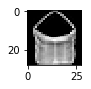

Real:  Dress


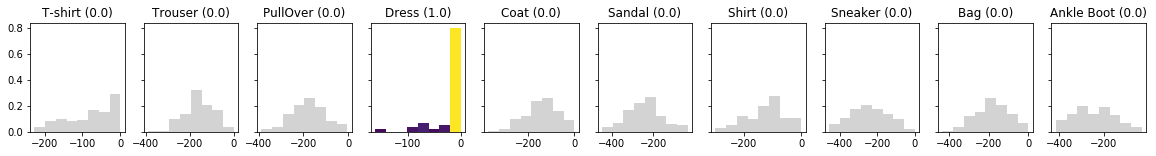

Correct


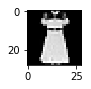

Real:  Coat


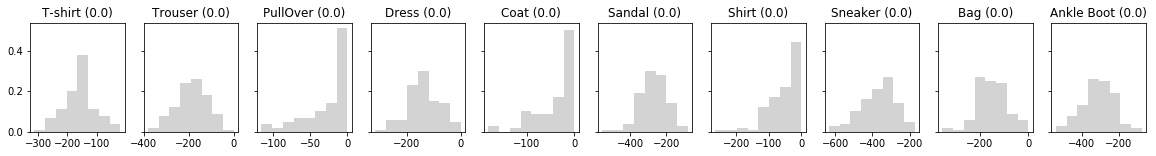

Undecided.


Real:  T-shirt


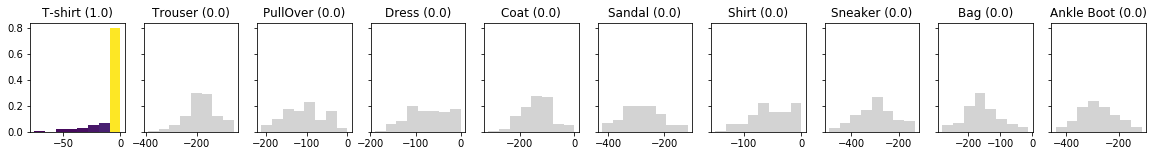

Correct


Real:  Bag


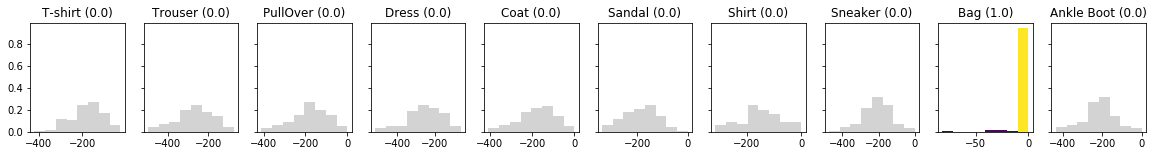

Correct


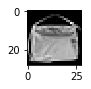

Real:  Ankle Boot


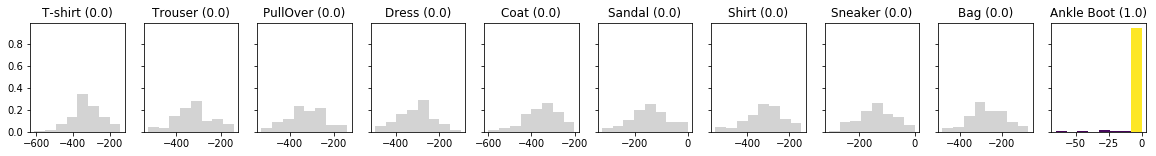

Correct


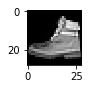

Real:  Trouser


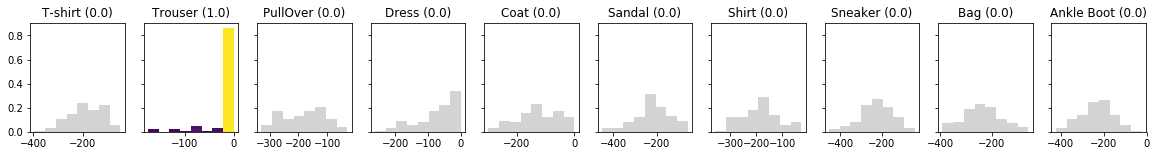

Correct


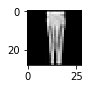

Real:  PullOver


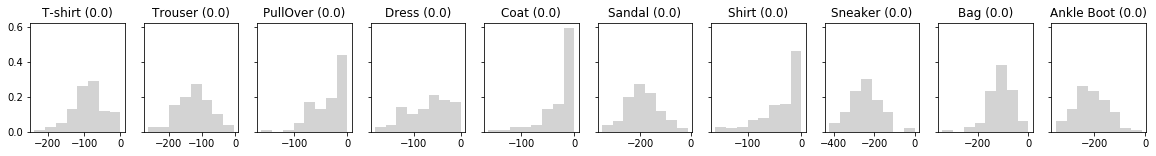

Undecided.


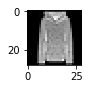

Real:  Coat


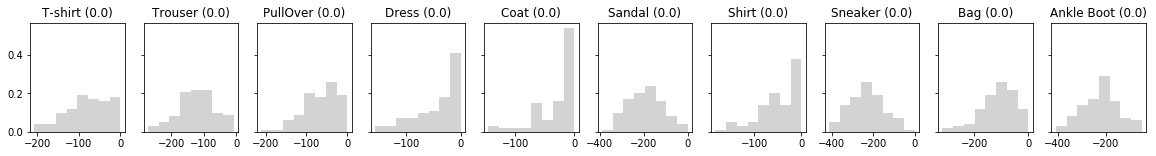

Undecided.


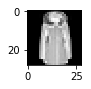

Real:  Dress


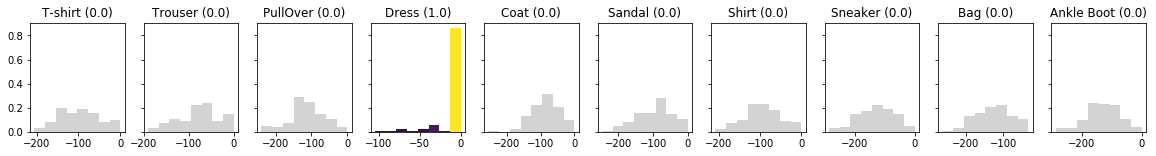

Correct


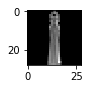

Real:  Bag


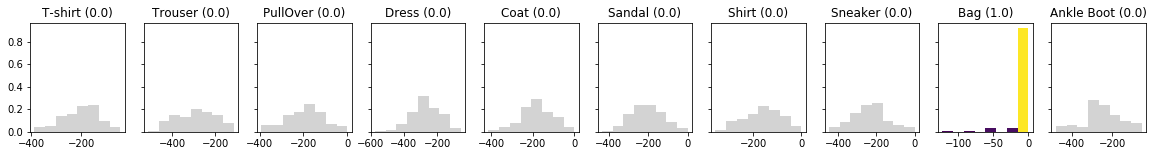

Correct


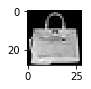

Real:  Coat


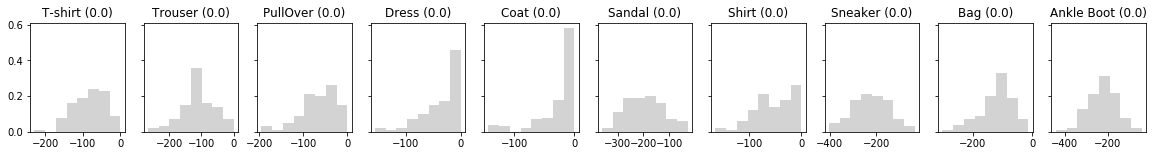

Undecided.


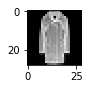

Real:  Sneaker


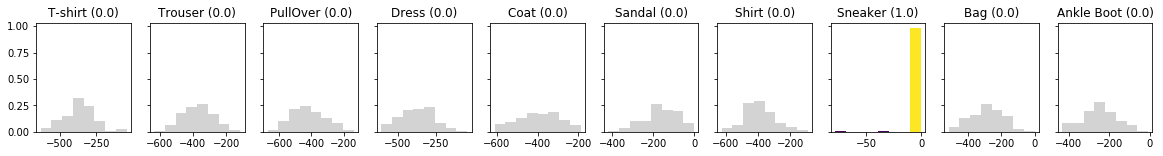

Correct


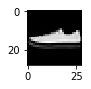

Real:  Trouser


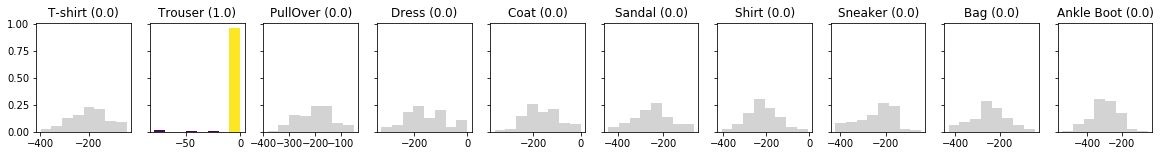

Correct


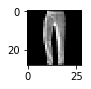

Real:  Sandal


Undecided.


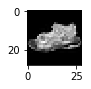

Real:  Ankle Boot


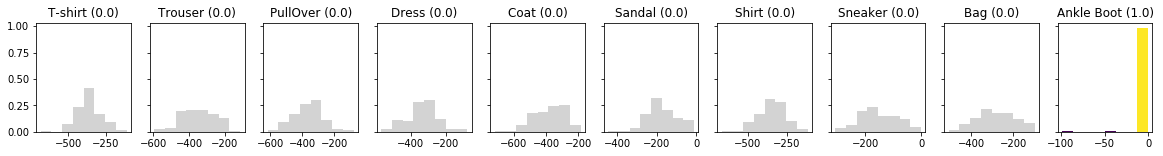

Correct


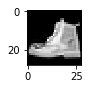

Real:  Sneaker


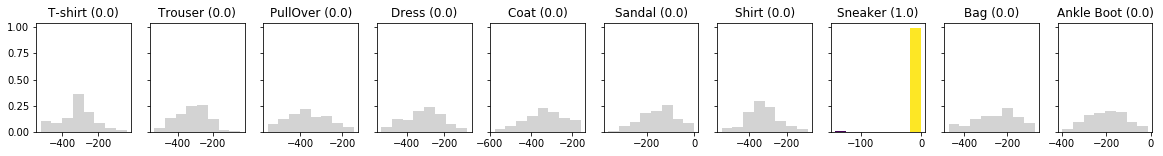

Correct


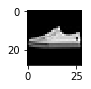

Real:  Trouser


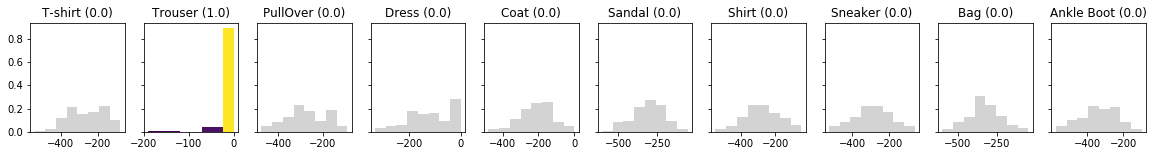

Correct


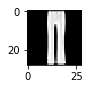

Real:  Dress


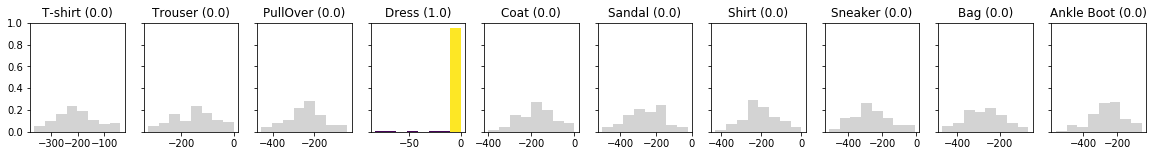

Correct


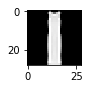

Real:  PullOver


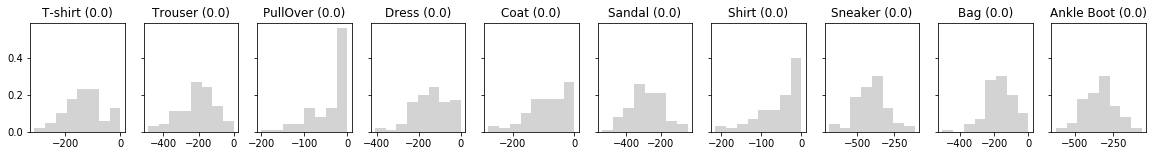

Undecided.


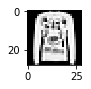

Real:  PullOver


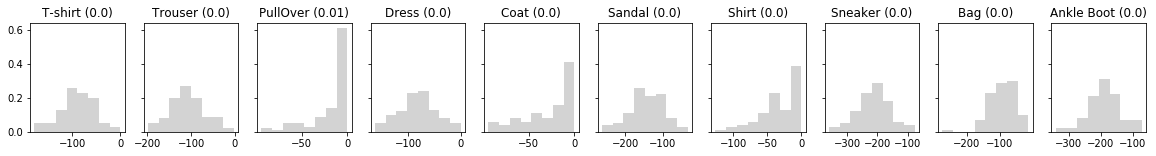

Undecided.


Summary
Total images:  100
Predicted for:  63
Accuracy when predicted:  0.9365079365079365


(100, 59.0, 63)

In [41]:
test_batch(images[:100], labels[:100])

In [42]:
# generate random data
images_random = torch.rand(100,28,28)
labels_random = torch.randint(0,10, (100,))

Real:  PullOver


Undecided.


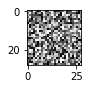

Real:  Sneaker


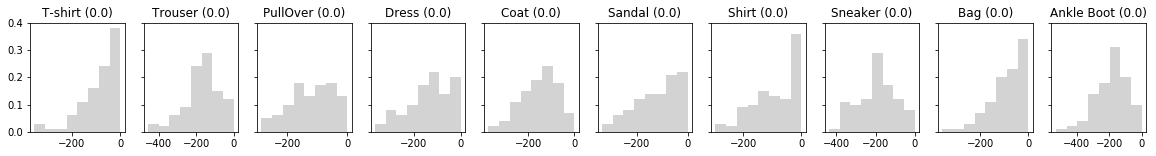

Undecided.


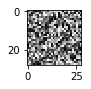

Real:  Shirt


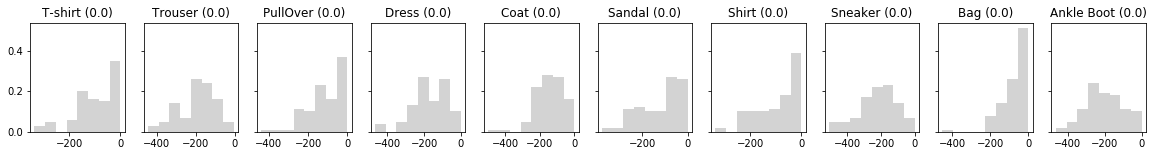

Undecided.


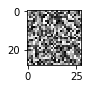

Real:  T-shirt


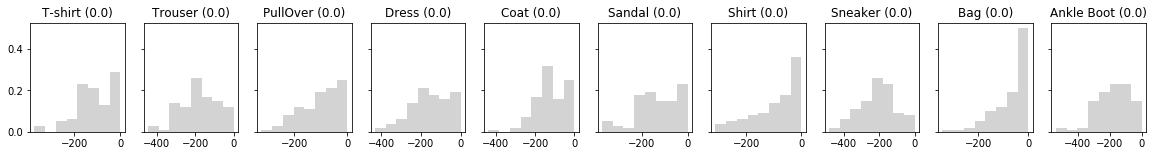

Undecided.


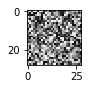

Real:  Ankle Boot


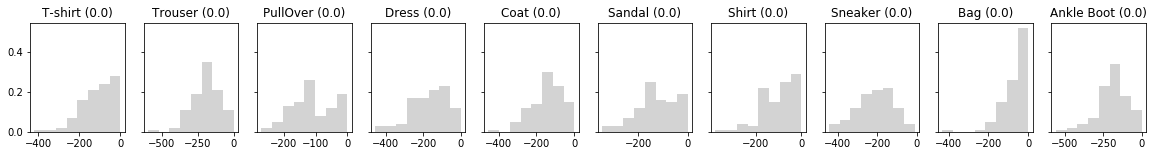

Undecided.


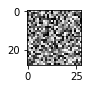

Real:  Dress


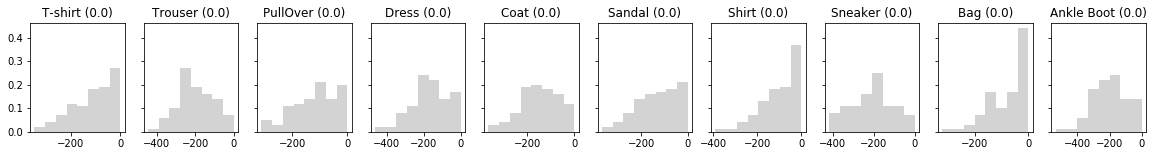

Undecided.


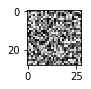

Real:  Sandal


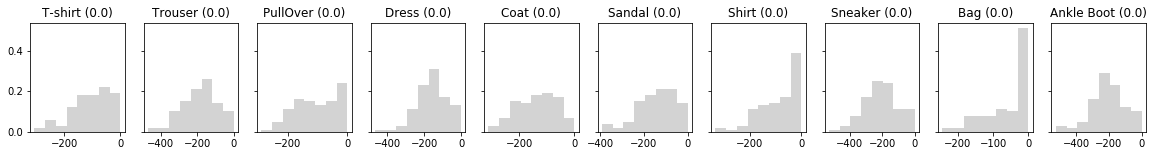

Undecided.


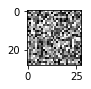

Real:  Shirt


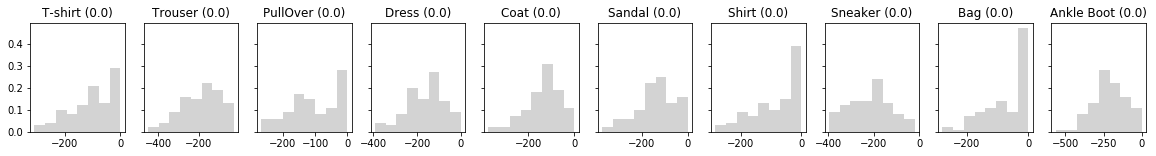

Undecided.


Real:  T-shirt


Undecided.


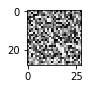

Real:  Sandal


Undecided.


Real:  Trouser


Undecided.


Real:  T-shirt


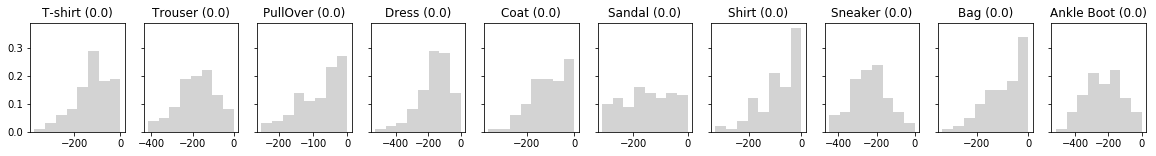

Undecided.


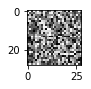

Real:  T-shirt


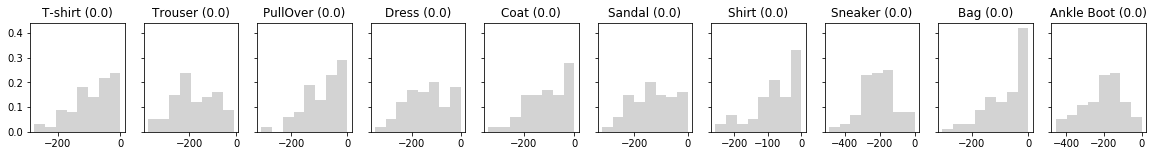

Undecided.


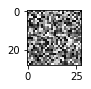

Real:  Dress


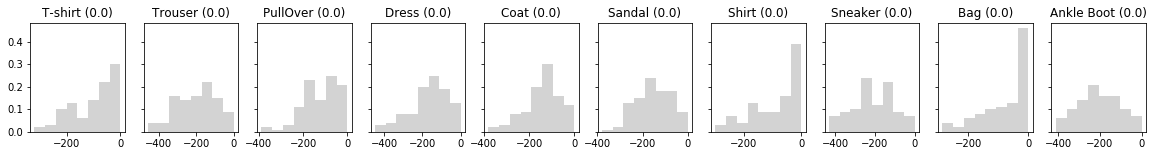

Undecided.


Real:  Shirt


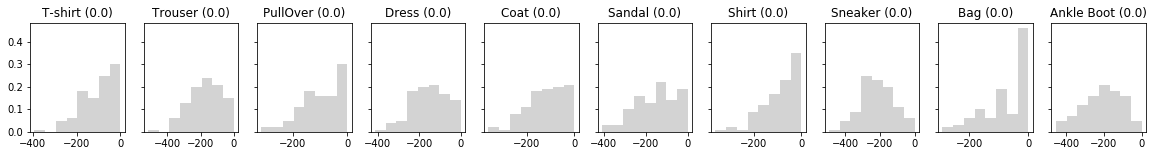

Undecided.


Real:  Shirt


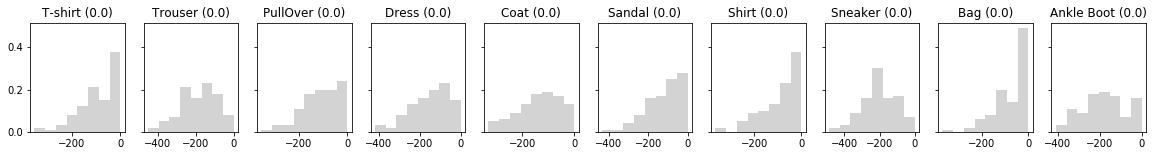

Undecided.


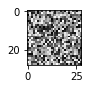

Real:  Coat


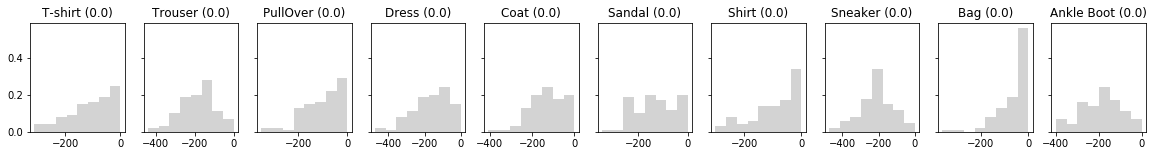

Undecided.


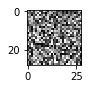

Real:  Trouser


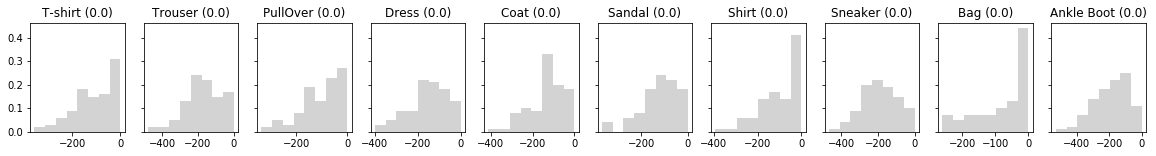

Undecided.


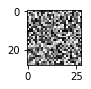

Real:  Coat


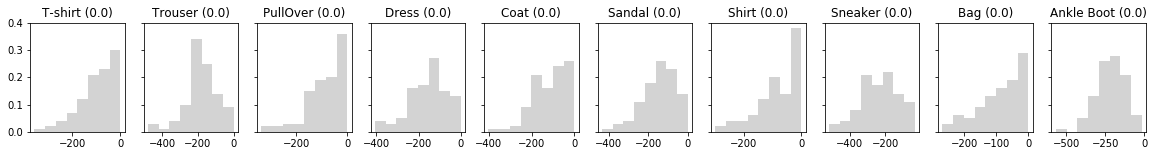

Undecided.


Real:  Sneaker


Undecided.


Real:  Sandal


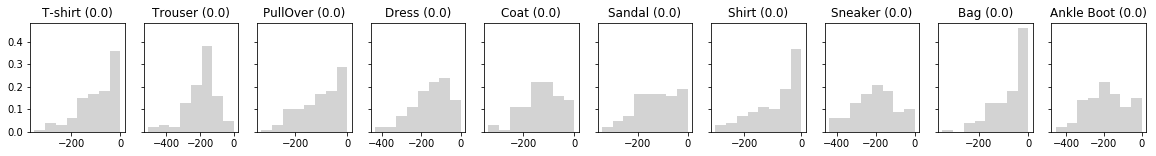

Undecided.


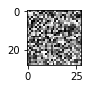

Real:  PullOver


Undecided.


Real:  Bag


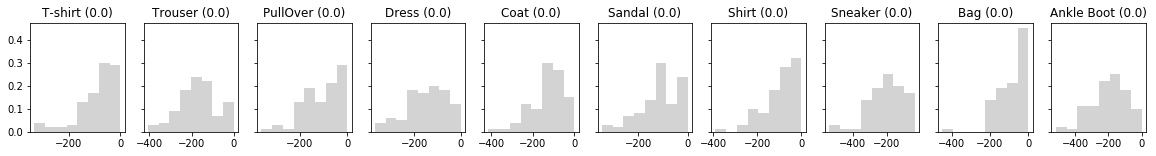

Undecided.


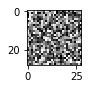

Real:  Ankle Boot


Undecided.


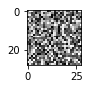

Real:  Trouser


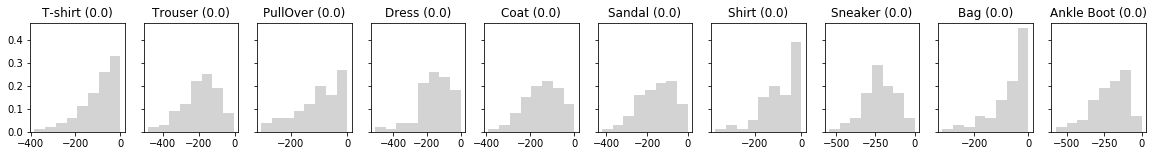

Undecided.


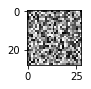

Real:  T-shirt


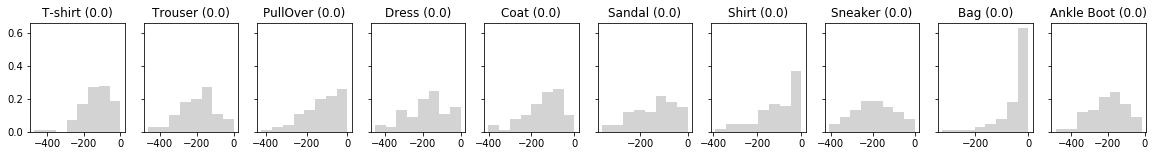

Undecided.


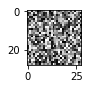

Real:  Sneaker


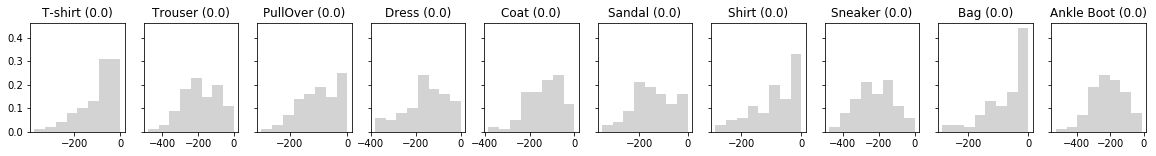

Undecided.


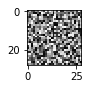

Real:  Dress


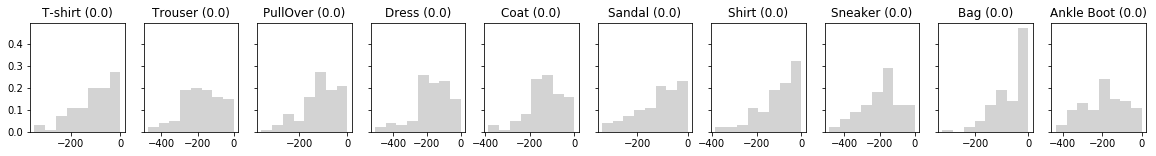

Undecided.


Real:  Coat


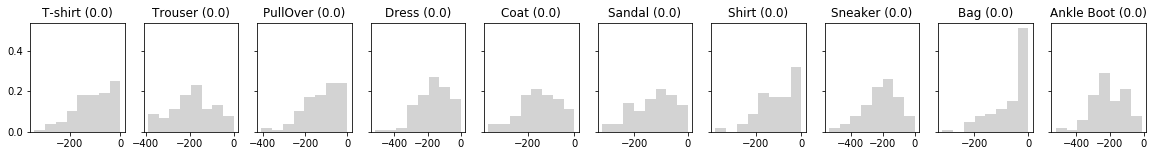

Undecided.


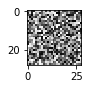

Real:  T-shirt


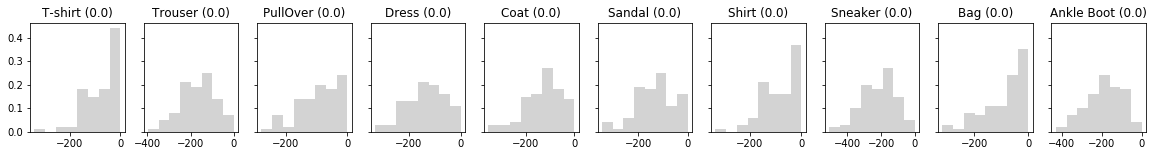

Undecided.


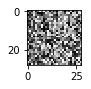

Real:  Dress


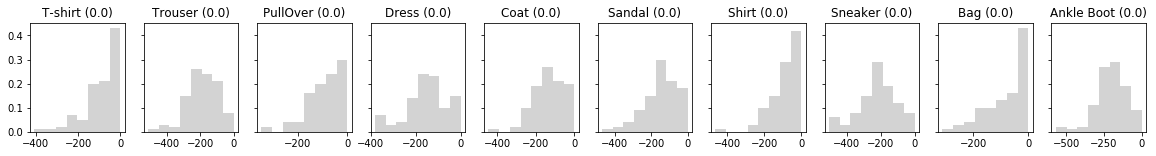

Undecided.


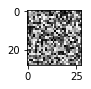

Real:  T-shirt


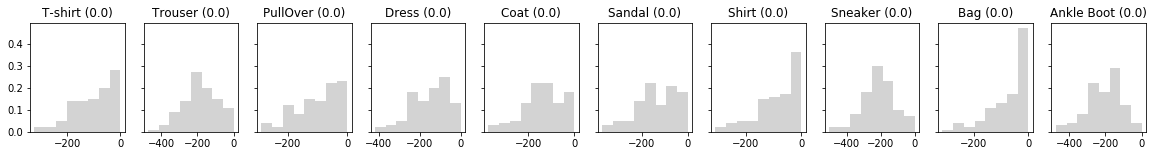

Undecided.


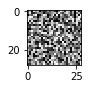

Real:  Sandal


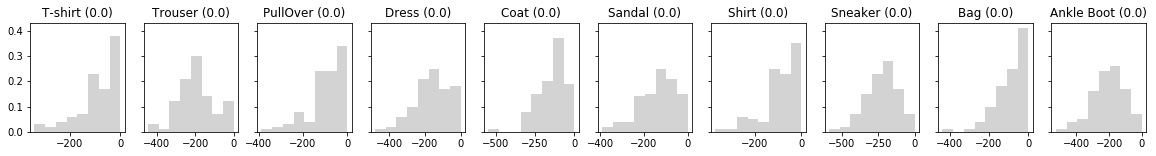

Undecided.


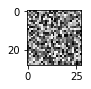

Real:  Ankle Boot


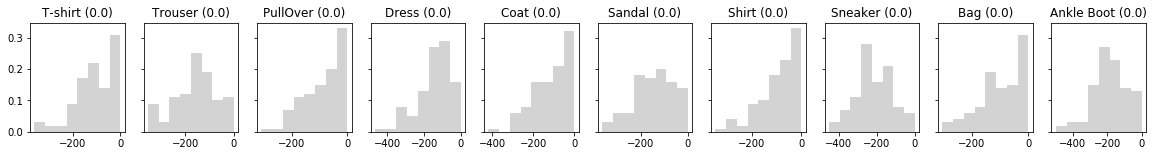

Undecided.


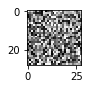

Real:  Ankle Boot


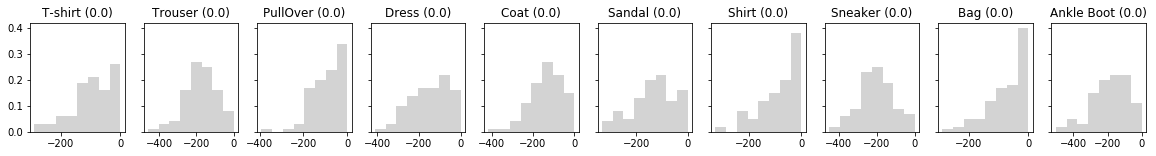

Undecided.


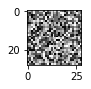

Real:  Coat


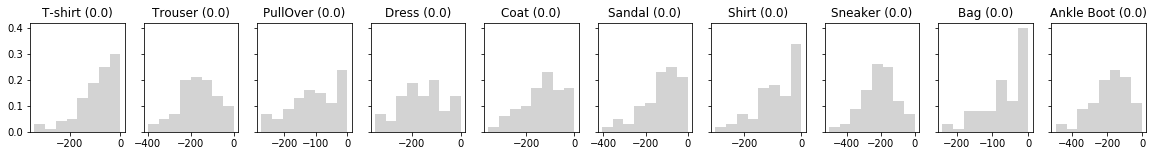

Undecided.


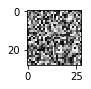

Real:  Sneaker


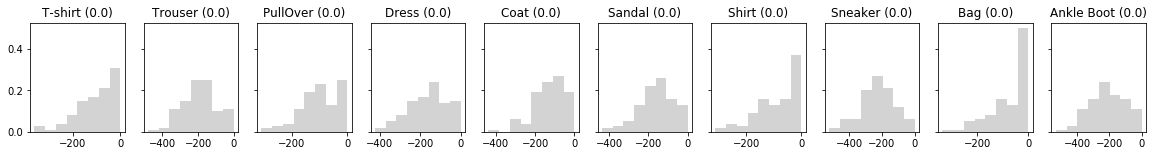

Undecided.


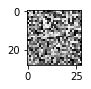

Real:  Sandal


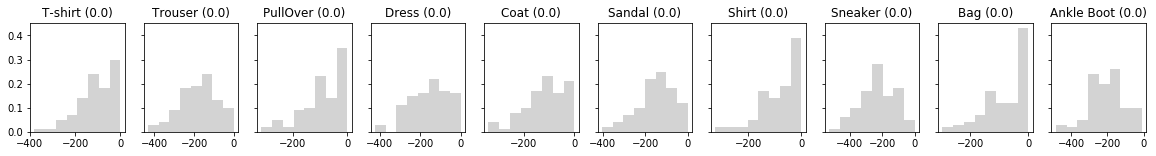

Undecided.


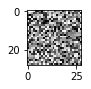

Real:  Coat


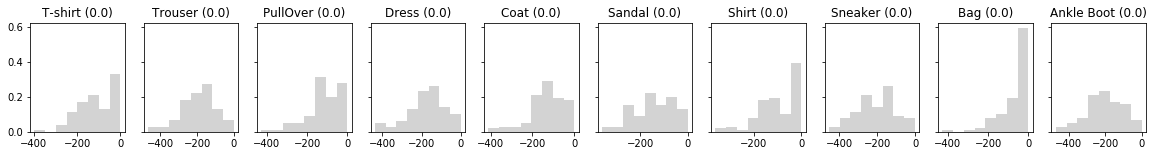

Undecided.


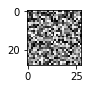

Real:  Trouser


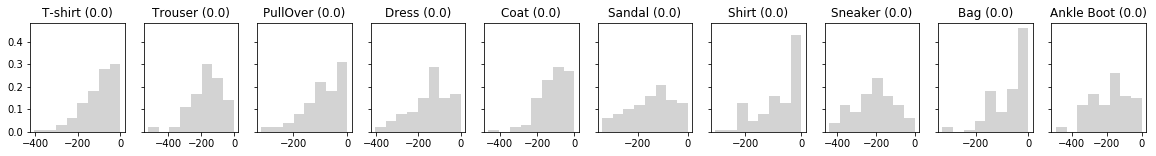

Undecided.


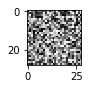

Real:  Sneaker


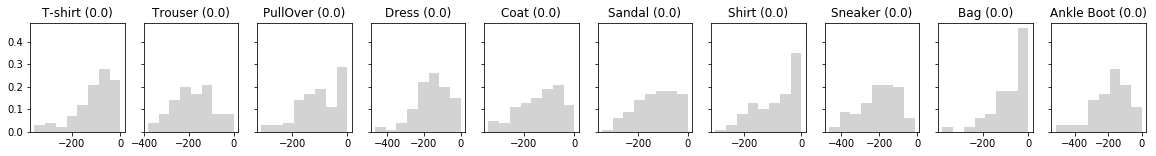

Undecided.


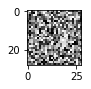

Real:  PullOver


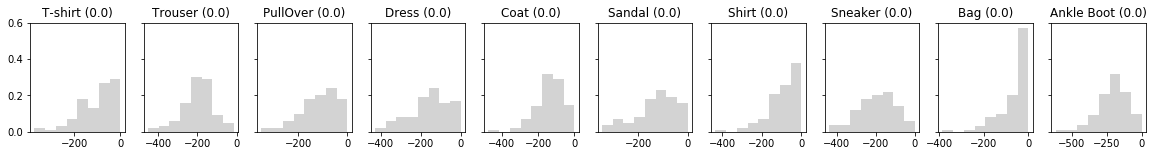

Undecided.


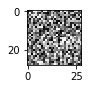

Real:  Coat


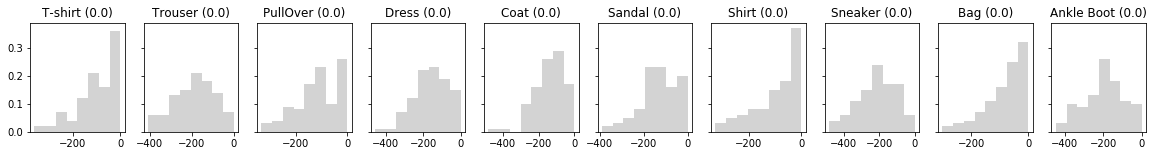

Undecided.


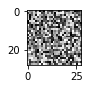

Real:  Coat


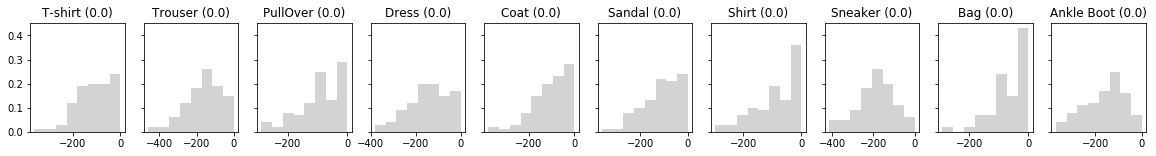

Undecided.


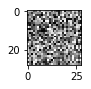

Real:  Bag


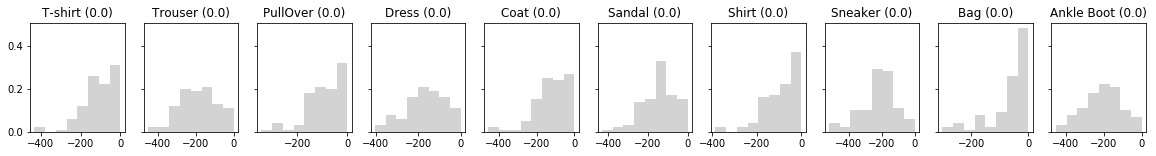

Undecided.


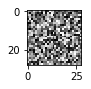

Real:  Coat


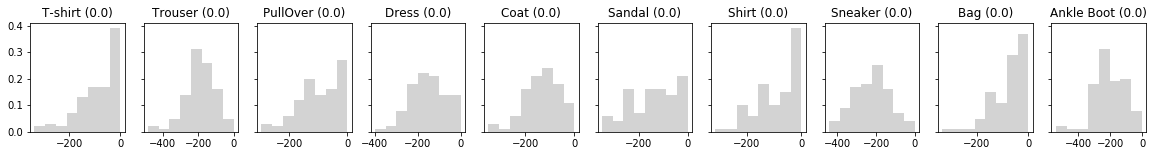

Undecided.


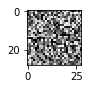

Real:  Sneaker


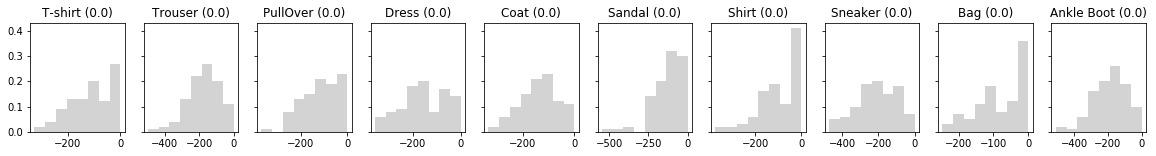

Undecided.


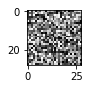

Real:  Ankle Boot


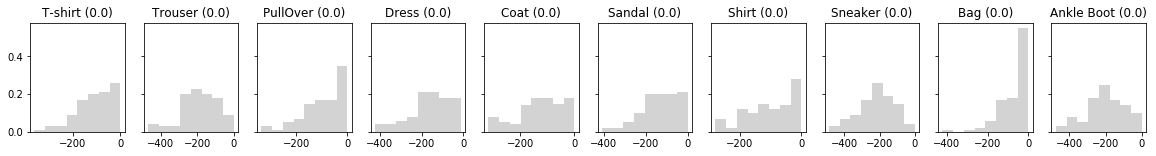

Undecided.


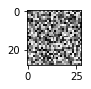

Real:  Dress


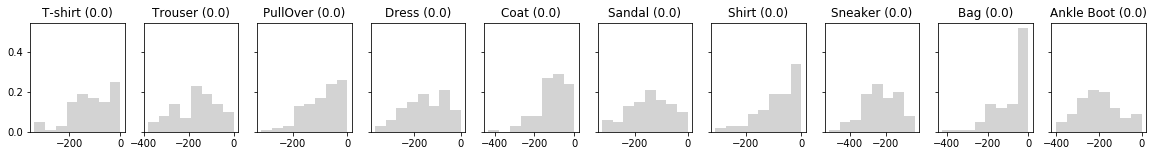

Undecided.


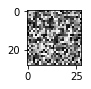

Real:  Sneaker


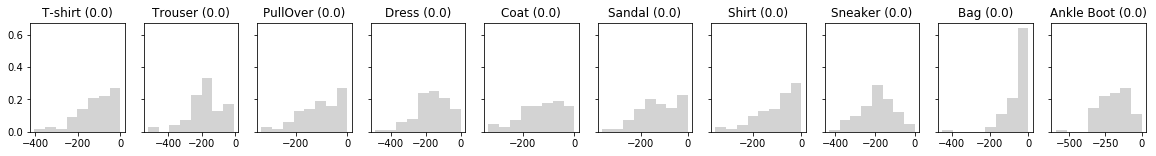

Undecided.


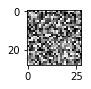

Real:  Sandal


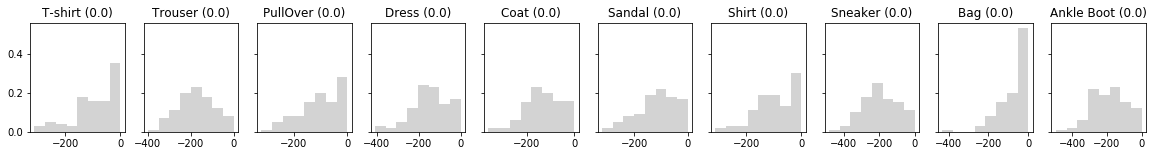

Undecided.


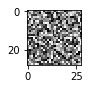

Real:  Sneaker


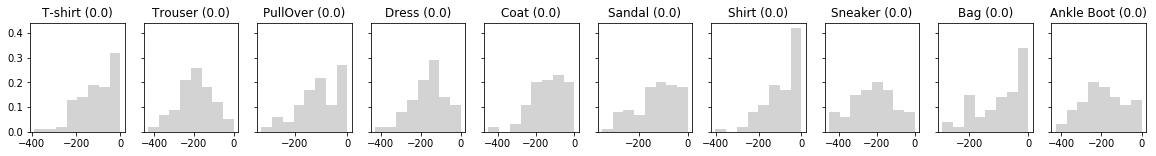

Undecided.


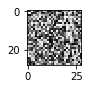

Real:  Bag


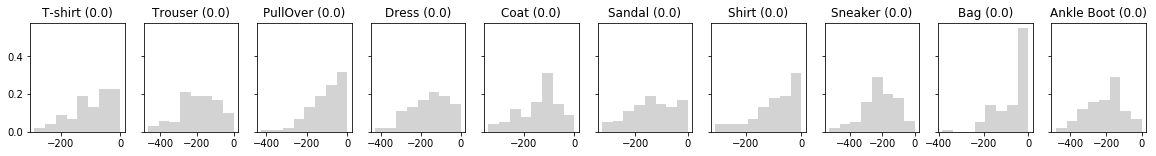

Undecided.


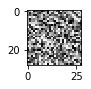

Real:  Shirt


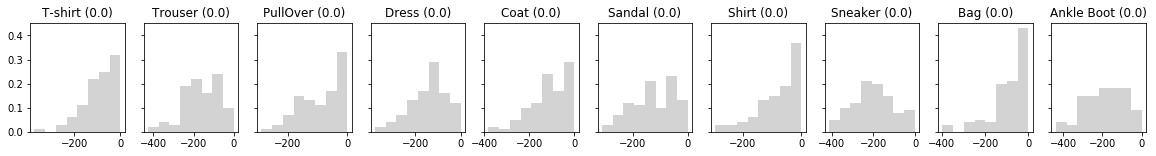

Undecided.


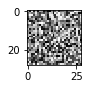

Real:  Coat


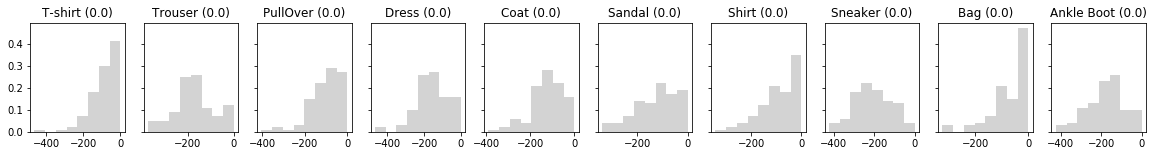

Undecided.


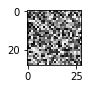

Real:  Bag


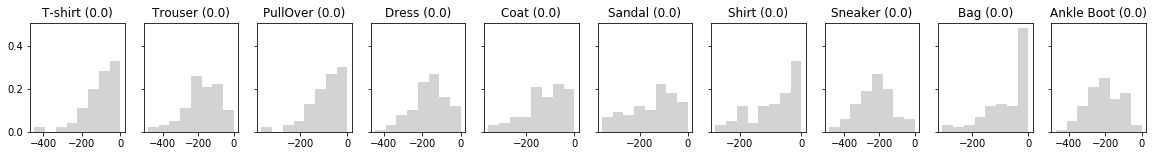

Undecided.


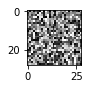

Real:  Dress


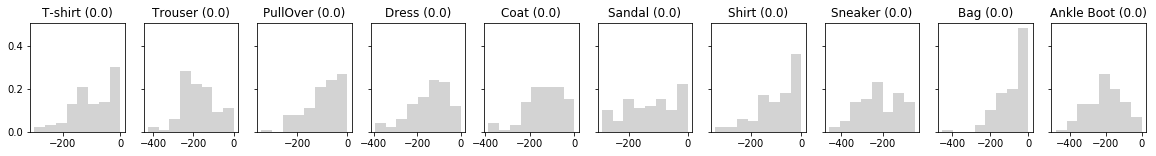

Undecided.


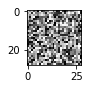

Real:  Ankle Boot


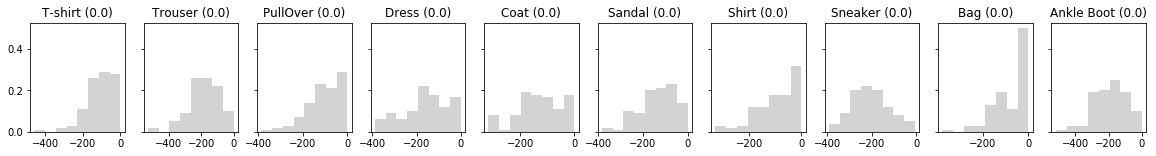

Undecided.


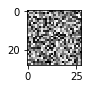

Real:  Coat


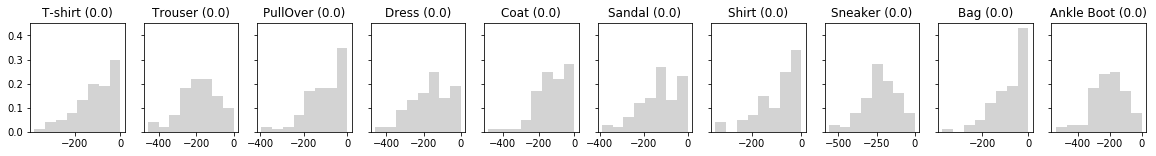

Undecided.


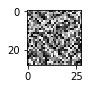

Real:  Sandal


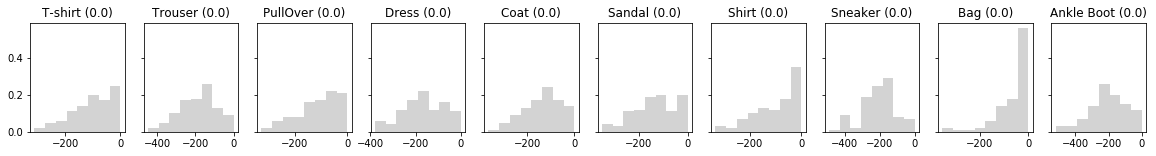

Undecided.


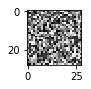

Real:  Coat


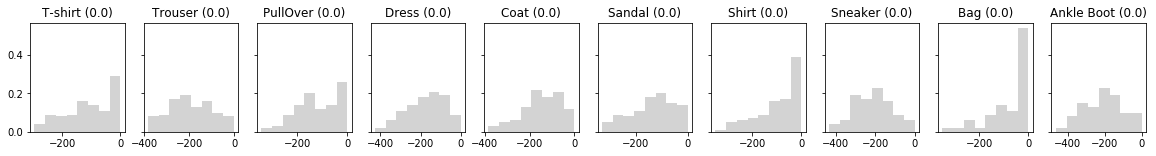

Undecided.


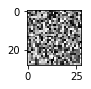

Real:  Ankle Boot


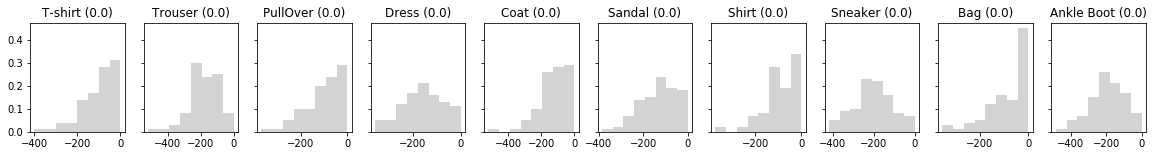

Undecided.


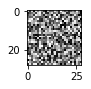

Real:  Shirt


Undecided.


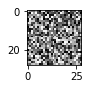

Real:  Sneaker


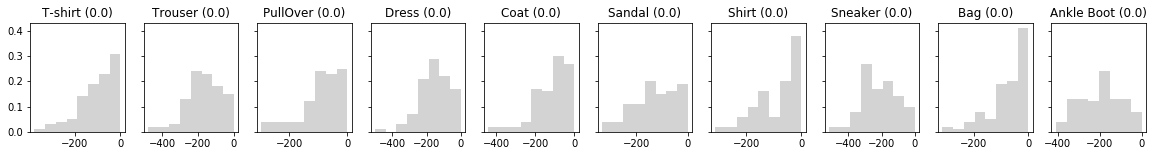

Undecided.


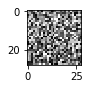

Real:  PullOver


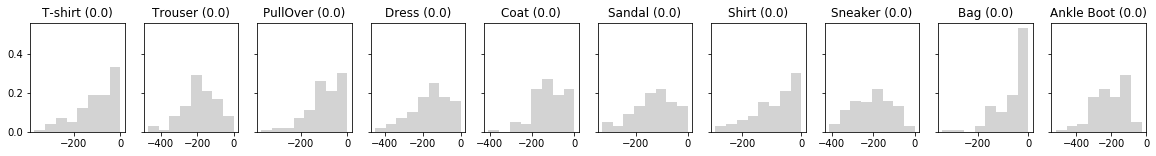

Undecided.


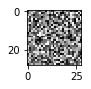

Real:  Coat


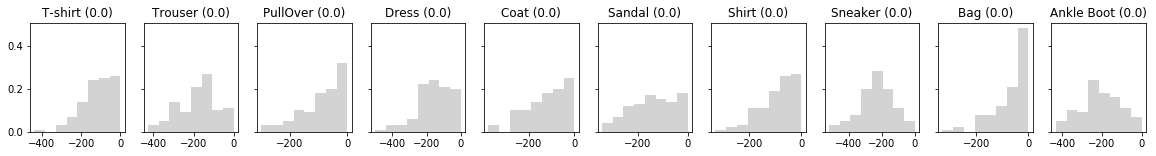

Undecided.


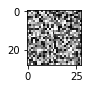

Real:  Shirt


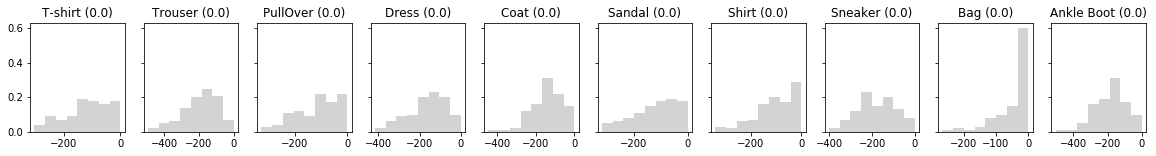

Undecided.


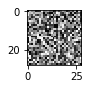

Real:  Shirt


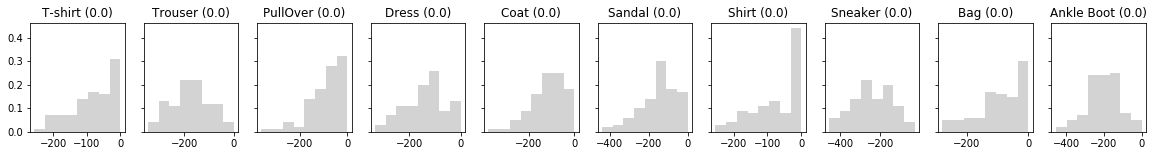

Undecided.


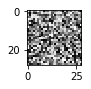

Real:  Coat


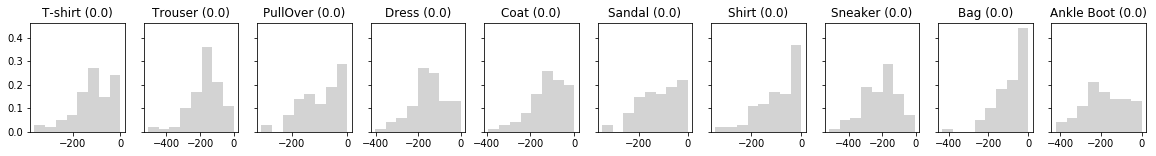

Undecided.


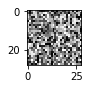

Real:  T-shirt


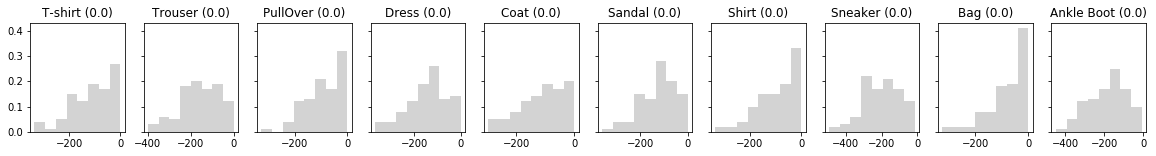

Undecided.


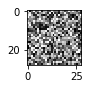

Real:  Shirt


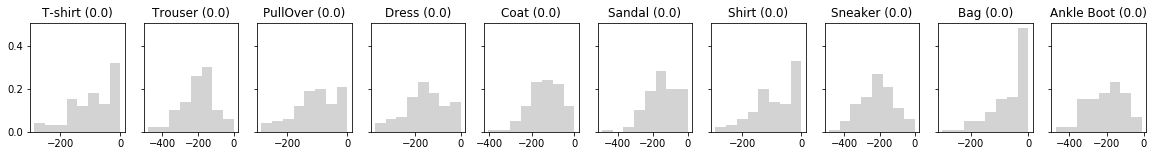

Undecided.


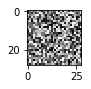

Real:  Trouser


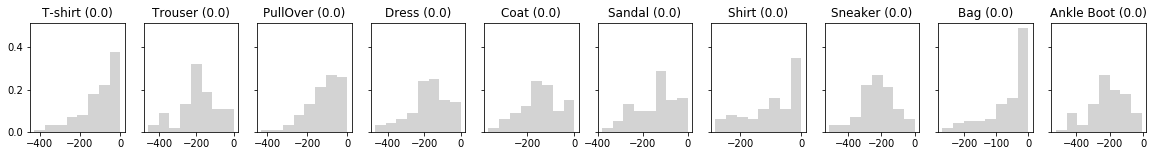

Undecided.


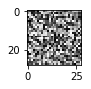

Real:  Coat


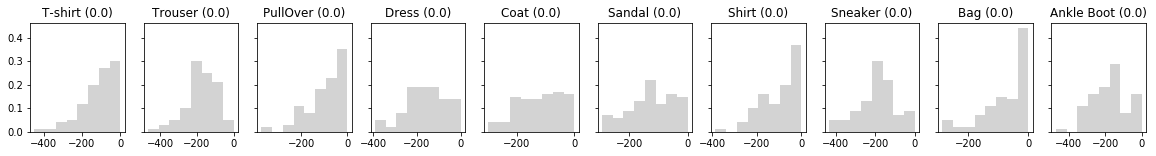

Undecided.


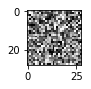

Real:  Ankle Boot


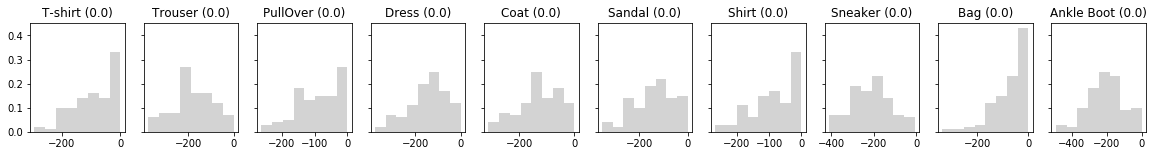

Undecided.


Real:  PullOver


Undecided.


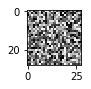

Real:  Shirt


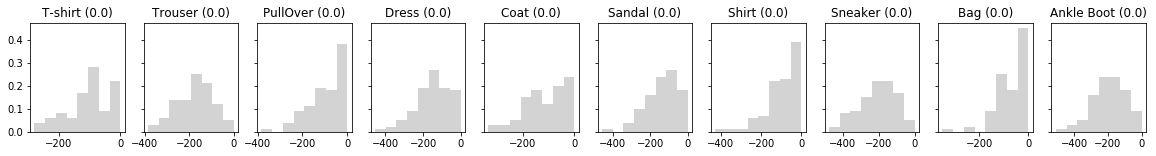

Undecided.


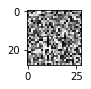

Real:  PullOver


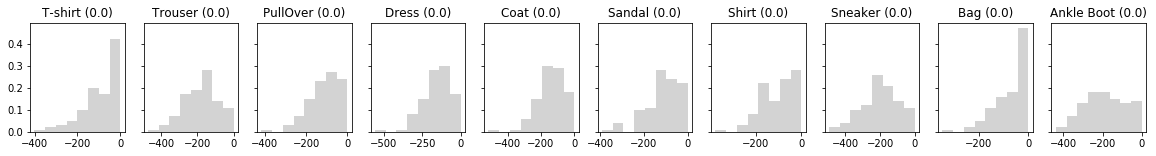

Undecided.


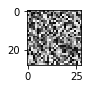

Real:  Sandal


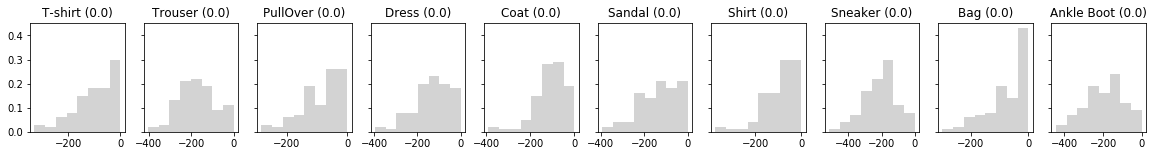

Undecided.


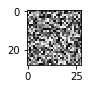

Real:  T-shirt


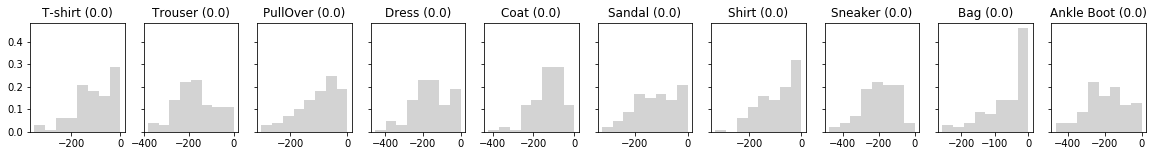

Undecided.


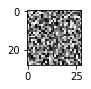

Real:  Shirt


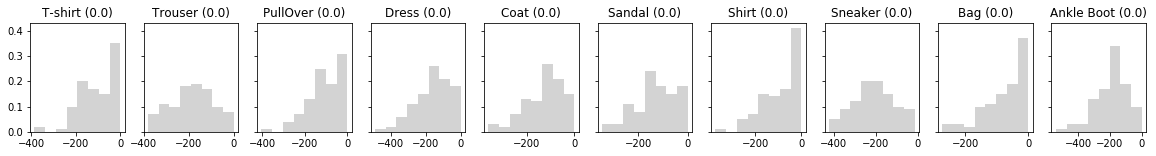

Undecided.


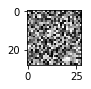

Real:  Dress


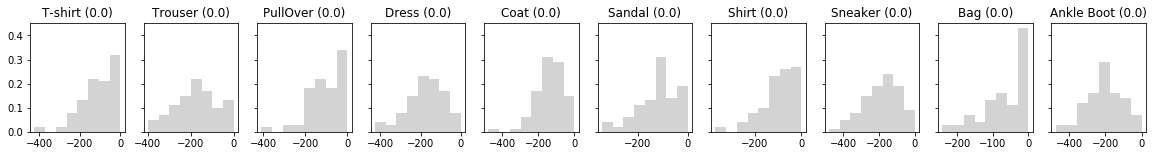

Undecided.


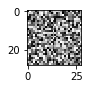

Real:  Sneaker


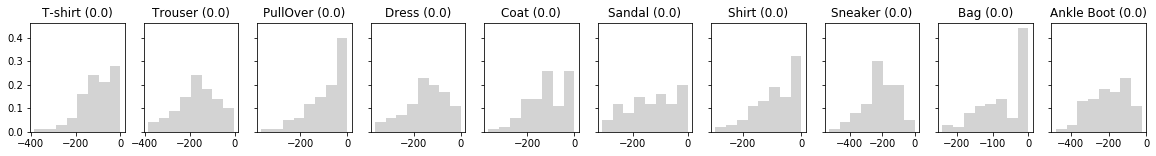

Undecided.


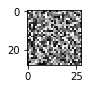

Real:  PullOver


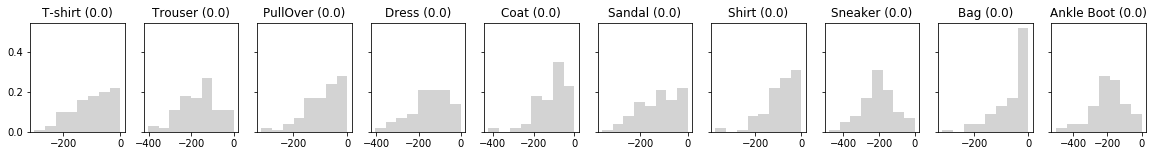

Undecided.


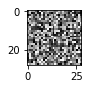

Real:  Sneaker


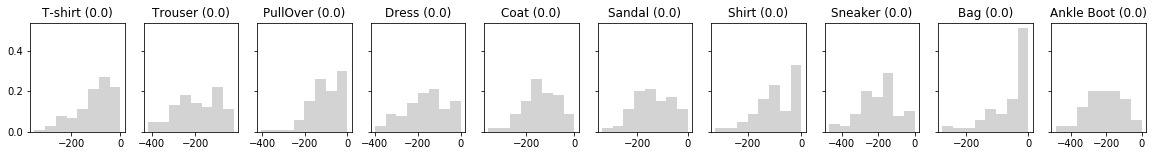

Undecided.


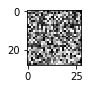

Real:  Trouser


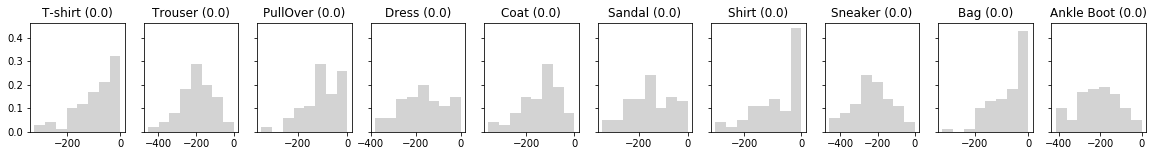

Undecided.


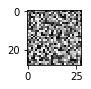

Real:  Bag


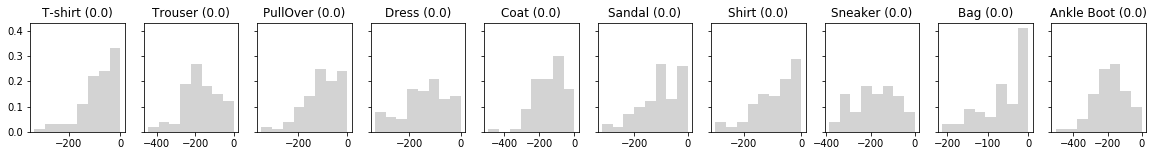

Undecided.


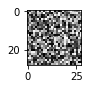

Real:  Sandal


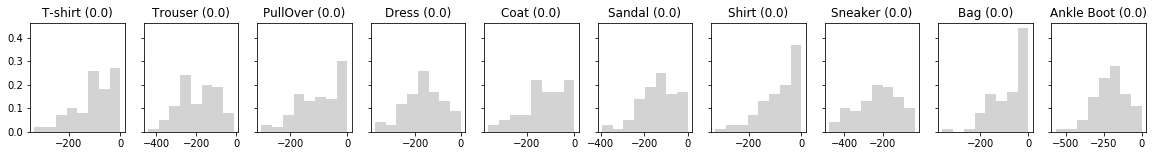

Undecided.


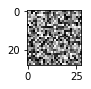

Real:  PullOver


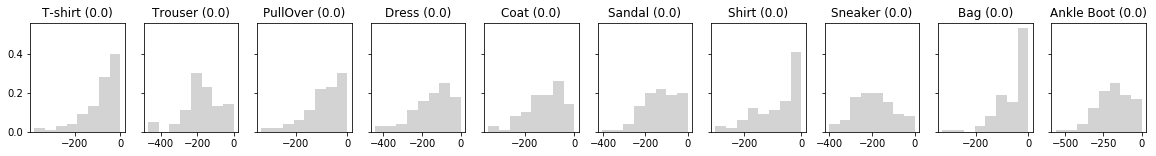

Undecided.


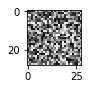

Real:  Coat


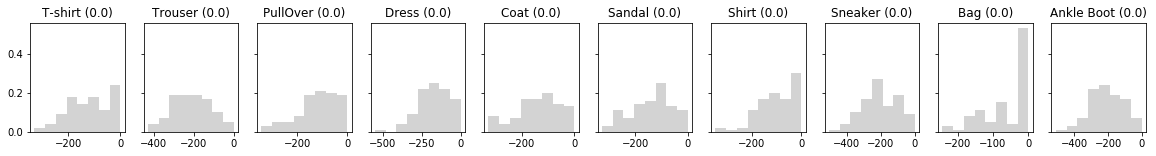

Undecided.


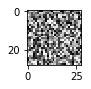

Real:  Dress


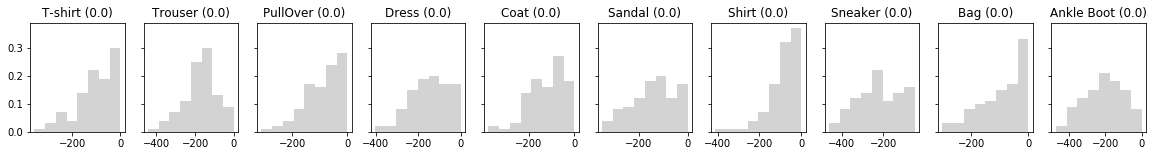

Undecided.


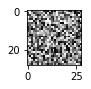

Real:  Bag


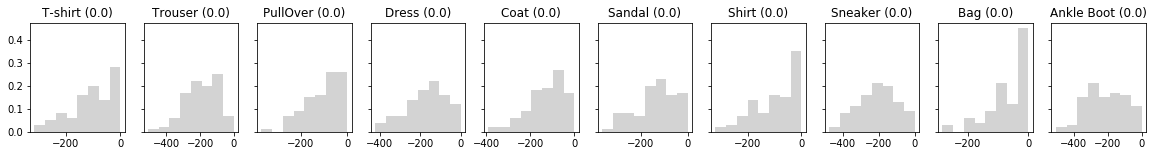

Undecided.


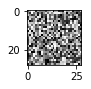

Real:  Sneaker


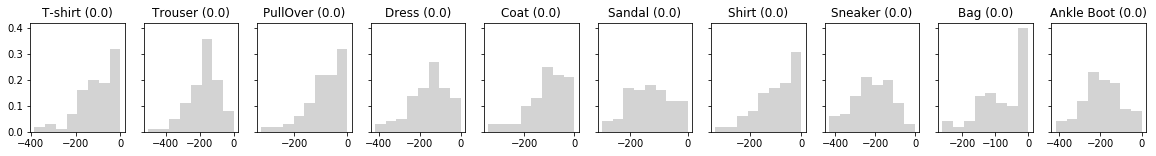

Undecided.


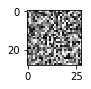

Real:  Sneaker


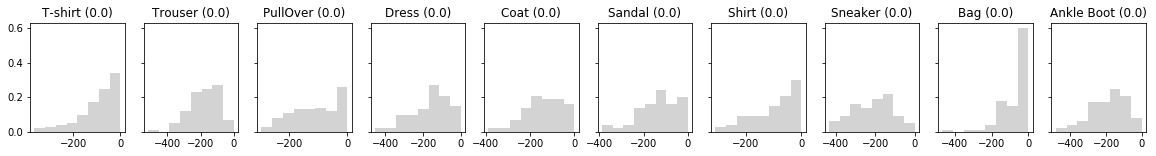

Undecided.


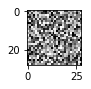

Real:  T-shirt


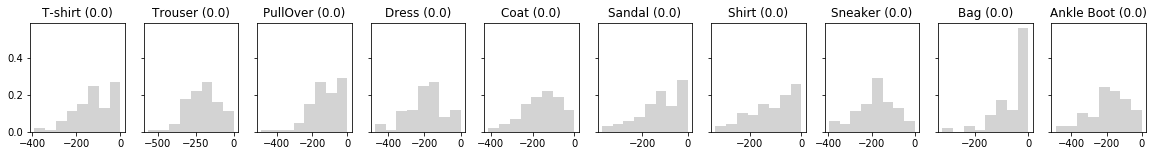

Undecided.


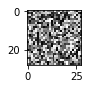

Real:  Sneaker


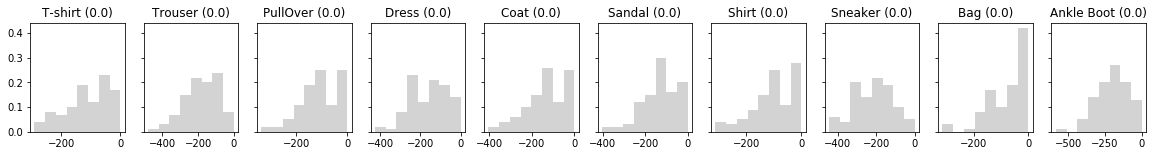

Undecided.


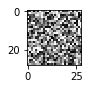

Real:  PullOver


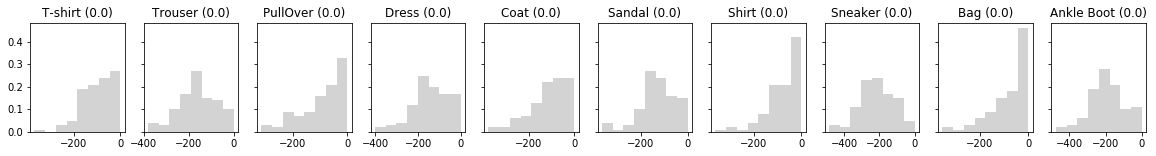

Undecided.


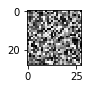

Real:  T-shirt


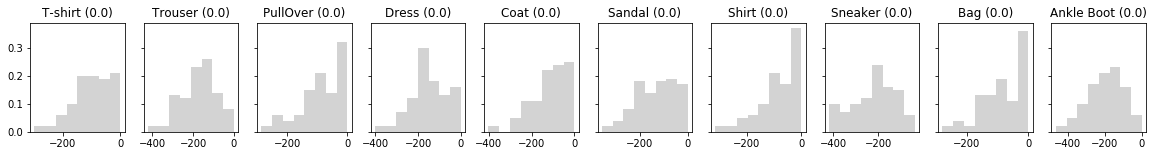

Undecided.


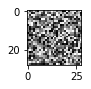

Real:  Shirt


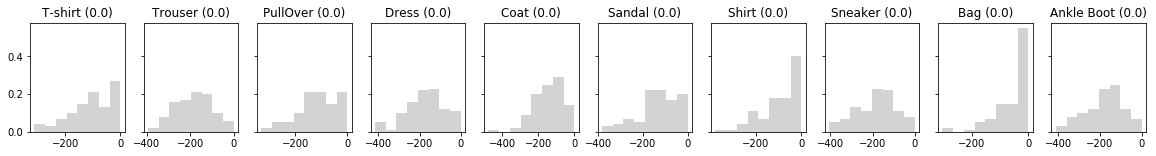

Undecided.


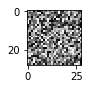

Real:  Dress


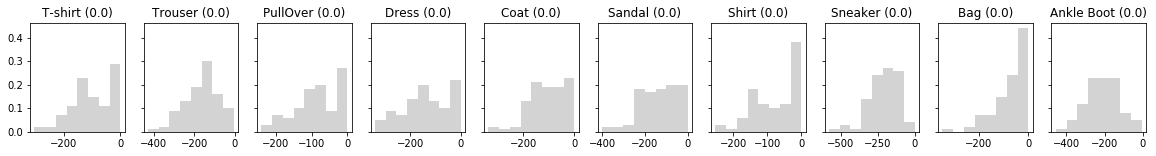

Undecided.


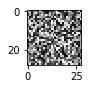

Real:  Sandal


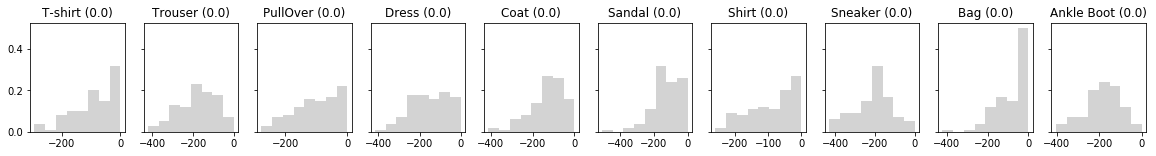

Undecided.


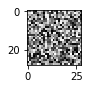

Summary
Total images:  100
Predicted for:  0


(100, 0, 0)

In [43]:
test_batch(images_random, labels_random)

In [44]:
class data_loader(Dataset):
	def __init__(self, root):
		Images, Y = [], []
		folders = os.listdir(root)
		folders = folders[1:]

		for folder in folders:
            
			folder_path = os.path.join(root, folder)
			print(folder_path)
            
            
            
			for ims in os.listdir(folder_path):

				img_path = os.path.join(folder_path, ims)
				Images.append(np.array(imread(img_path)))
				Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
				
		data = [(x, y) for x, y in zip(Images, Y)]
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		img = self.data[index][0]

		# 8 bit images. Scale between 0, 1
		img = img.reshape(1, 28, 28) / 255

		# Input for Conv2D should be Channels x Height x Width
		img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
		label = self.data[index][1]
		return (img_tensor, label)

In [45]:
# NOT Mnist data

test_dataset_notmnist = data_loader('not-mnist')
test_loader_notmnist = DataLoader(test_dataset_notmnist, batch_size=128, shuffle=True)

not-mnist/G
not-mnist/A
not-mnist/F
not-mnist/H
not-mnist/J
not-mnist/C
not-mnist/D


/Users/rakshitsareen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


not-mnist/E
not-mnist/B


In [30]:
# Prediction when network can decide not to predict

print('Prediction on not-MNIST when network can refuse')
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader_notmnist):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)

Prediction on not-MNIST when network can refuse
Total images:  429
Skipped:  198


In [46]:
dataiter_notmnist = iter(test_loader_notmnist)
images_notmnist, labels_notmnist = dataiter_notmnist.next()

Real:  Dress


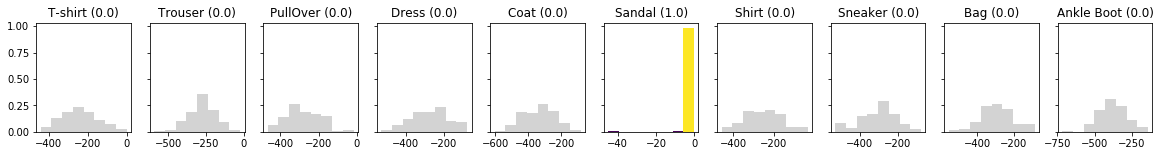

Incorrect :()


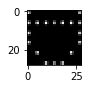

Real:  Coat


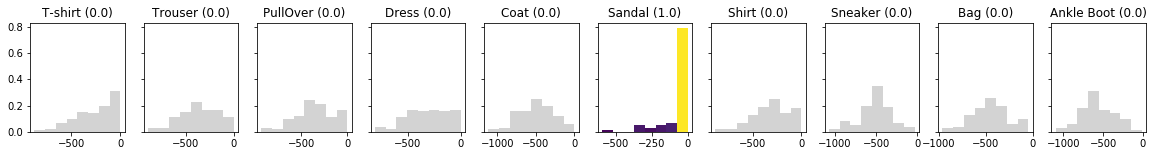

Incorrect :()


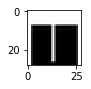

Real:  Trouser


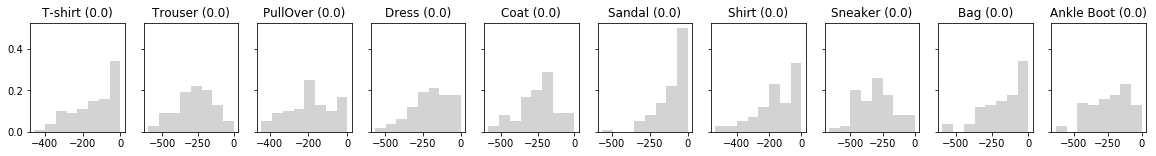

Undecided.


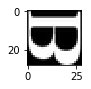

Real:  PullOver


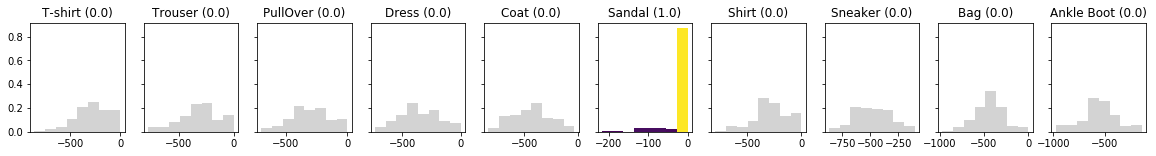

Incorrect :()


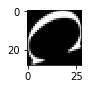

Real:  Dress


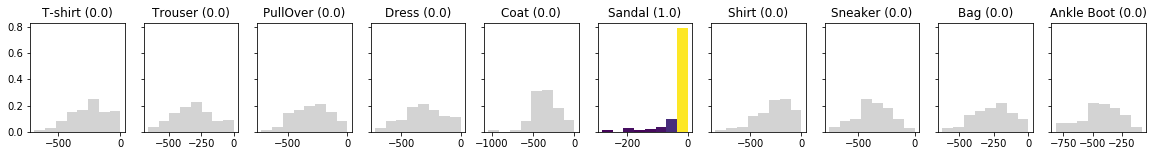

Incorrect :()


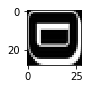

Real:  Shirt


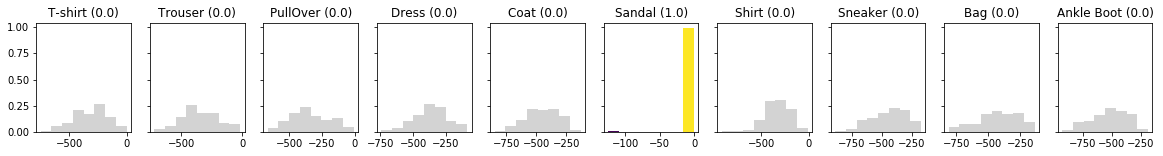

Incorrect :()


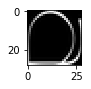

Real:  Sneaker


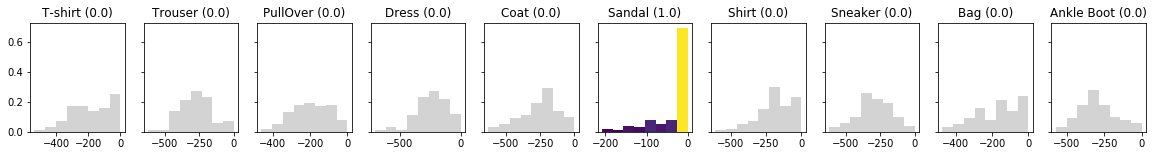

Incorrect :()


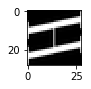

Real:  Trouser


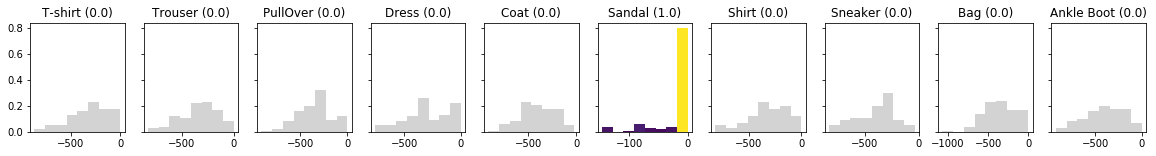

Incorrect :()


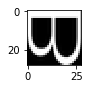

Real:  PullOver


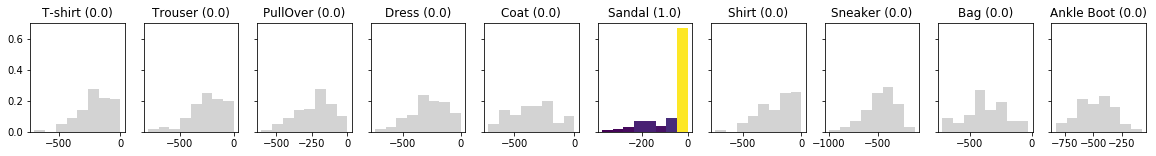

Incorrect :()


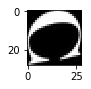

Real:  PullOver


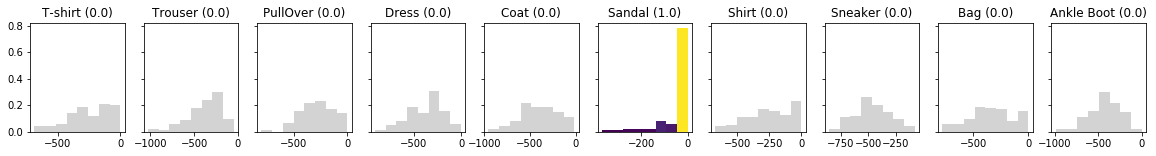

Incorrect :()


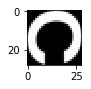

Real:  T-shirt


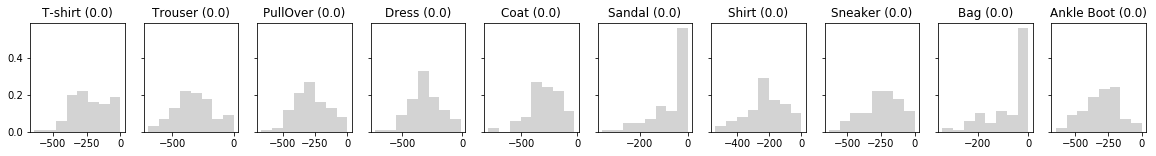

Undecided.


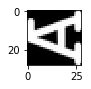

Real:  T-shirt


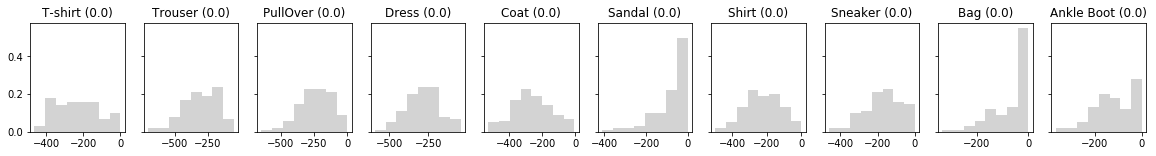

Undecided.


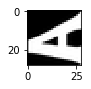

Real:  T-shirt


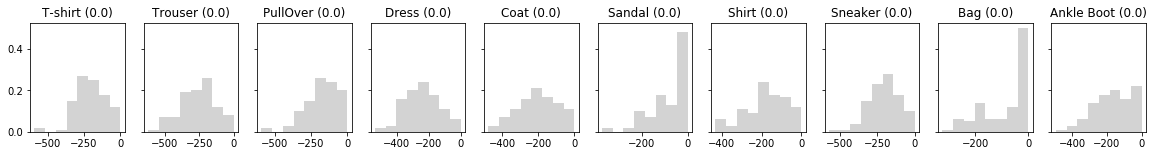

Undecided.


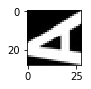

Real:  Coat


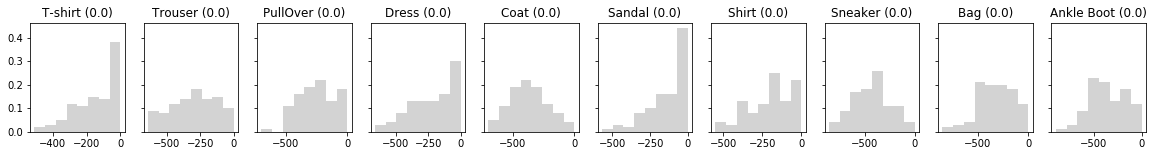

Undecided.


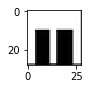

Real:  PullOver


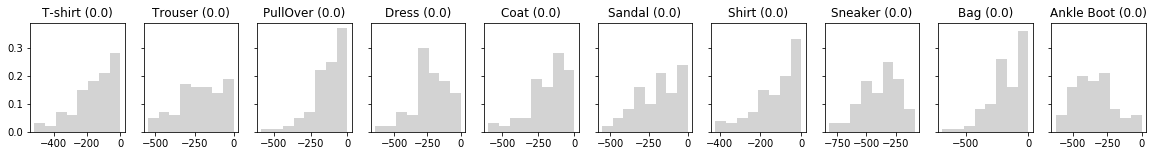

Undecided.


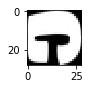

Real:  T-shirt


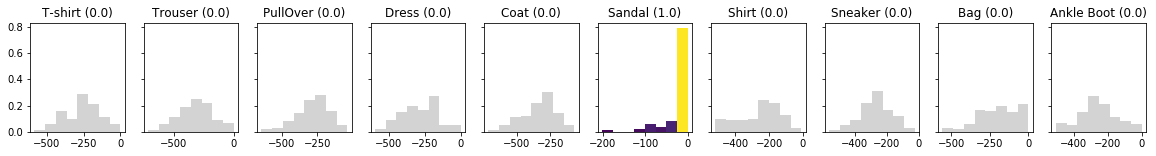

Incorrect :()


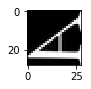

Real:  Sandal


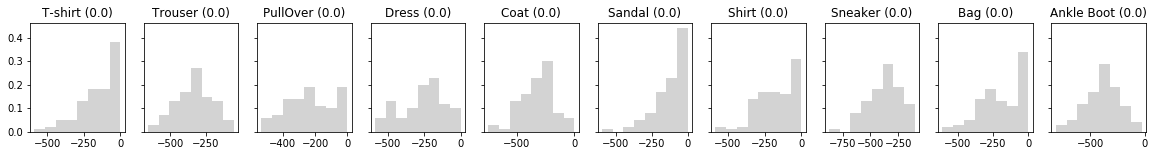

Undecided.


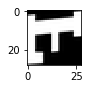

Real:  Coat


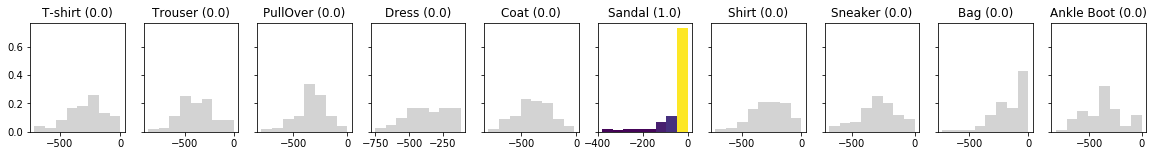

Incorrect :()


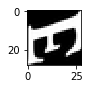

Real:  PullOver


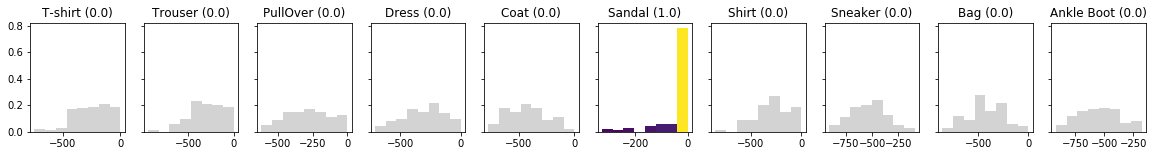

Incorrect :()


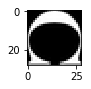

Real:  Shirt


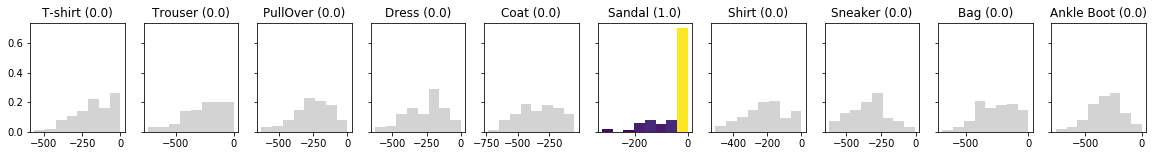

Incorrect :()


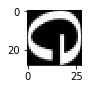

Real:  Sneaker


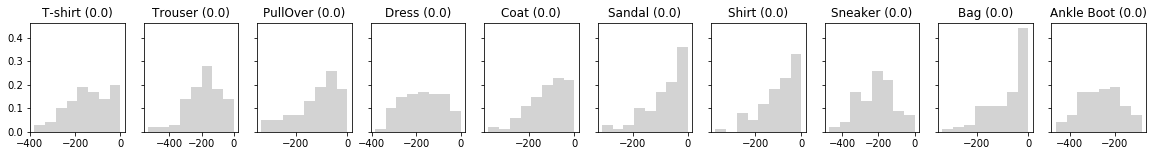

Undecided.


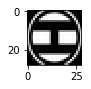

Real:  T-shirt


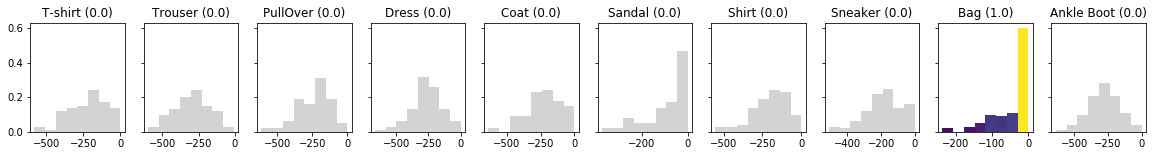

Incorrect :()


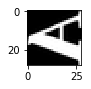

Real:  PullOver


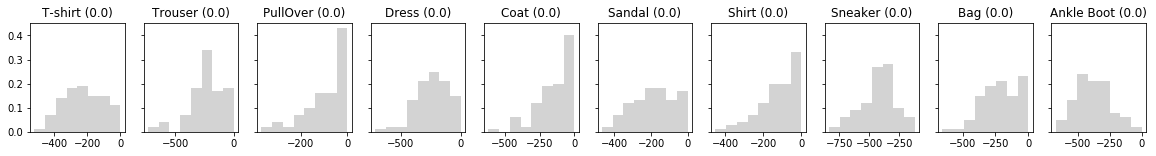

Undecided.


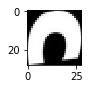

Real:  PullOver


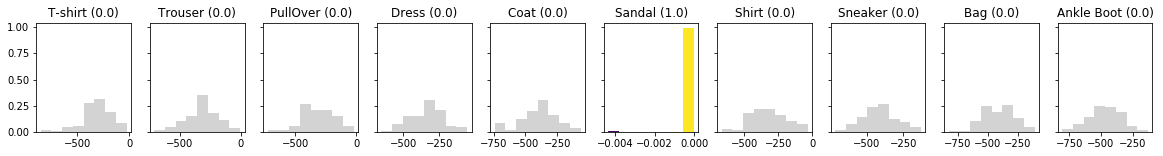

Incorrect :()


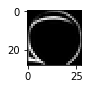

Real:  T-shirt


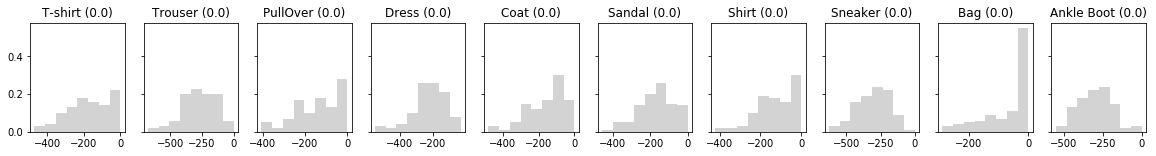

Undecided.


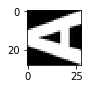

Real:  T-shirt


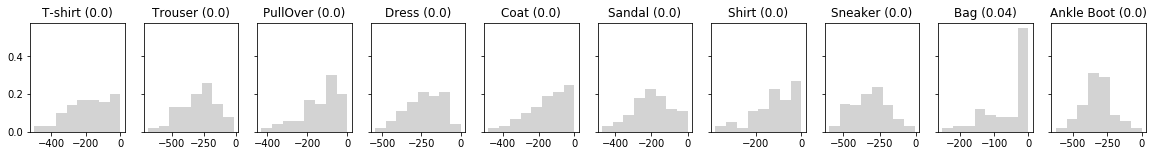

Undecided.


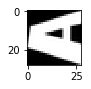

Real:  Ankle Boot


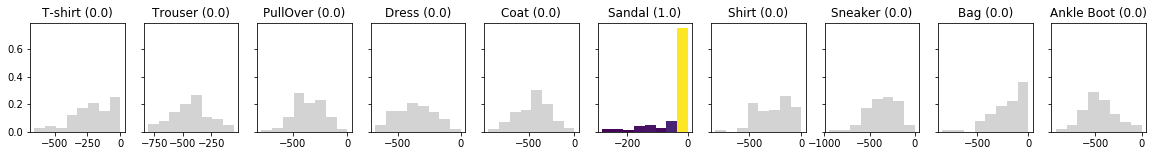

Incorrect :()


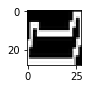

Real:  T-shirt


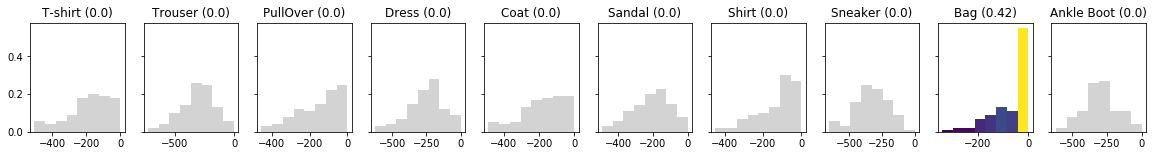

Incorrect :()


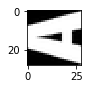

Real:  T-shirt


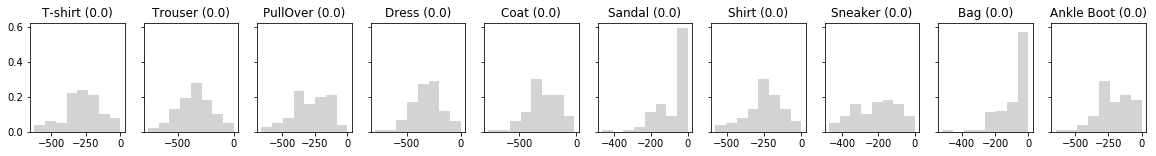

Undecided.


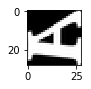

Real:  Sneaker


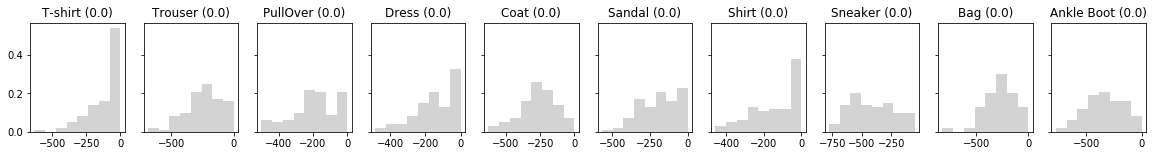

Undecided.


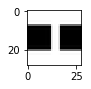

Real:  Ankle Boot


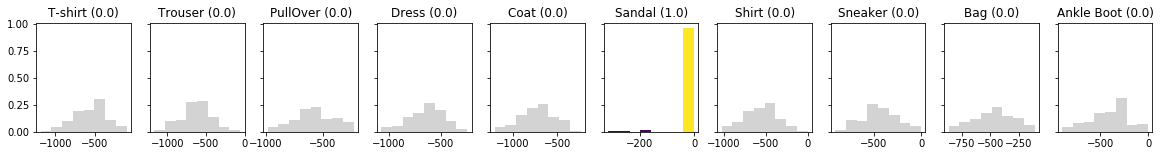

Incorrect :()


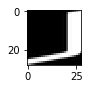

Real:  T-shirt


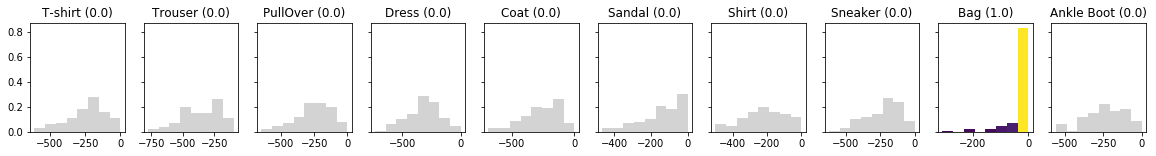

Incorrect :()


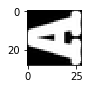

Real:  Trouser


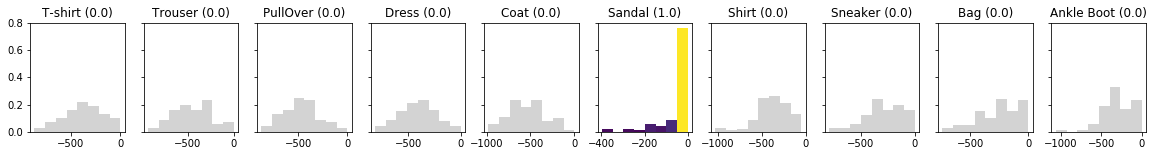

Incorrect :()


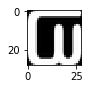

Real:  PullOver


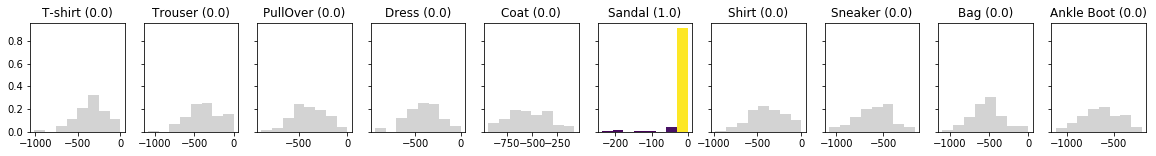

Incorrect :()


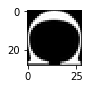

Real:  Trouser


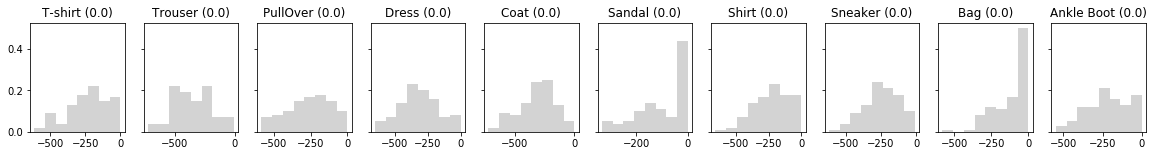

Undecided.


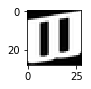

Real:  Coat


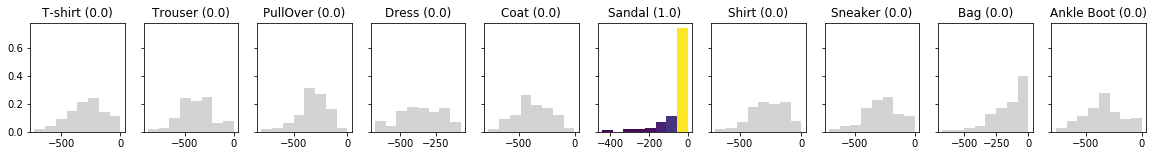

Incorrect :()


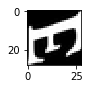

Real:  Ankle Boot


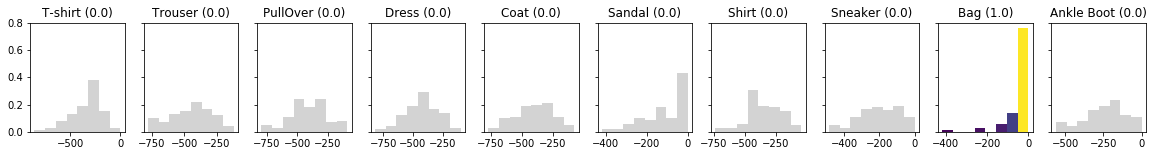

Incorrect :()


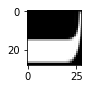

Real:  Dress


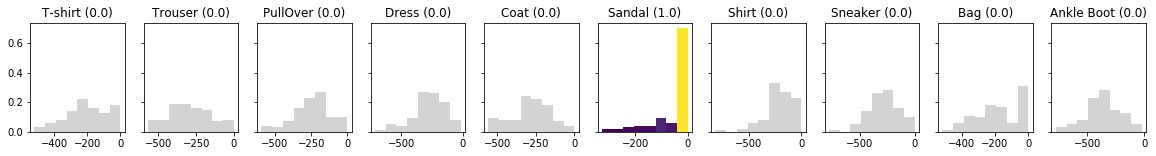

Incorrect :()


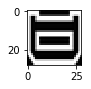

Real:  T-shirt


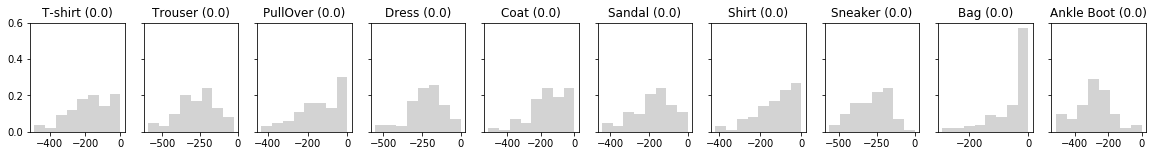

Undecided.


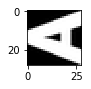

Real:  Shirt


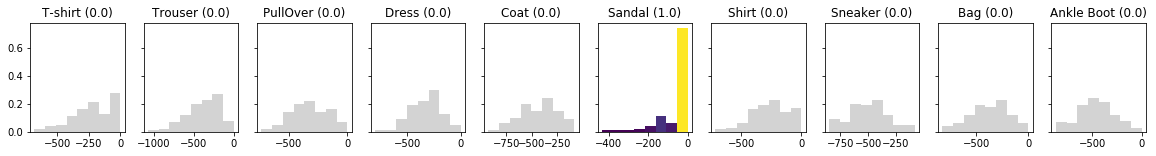

Incorrect :()


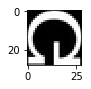

Real:  Shirt


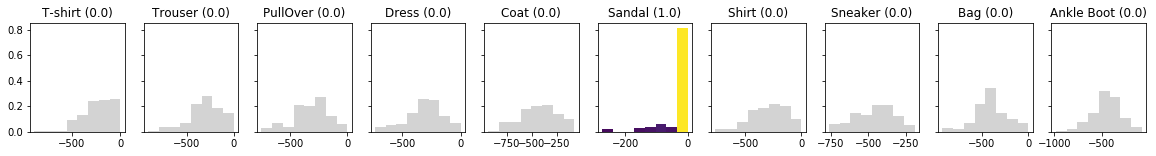

Incorrect :()


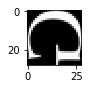

Real:  T-shirt


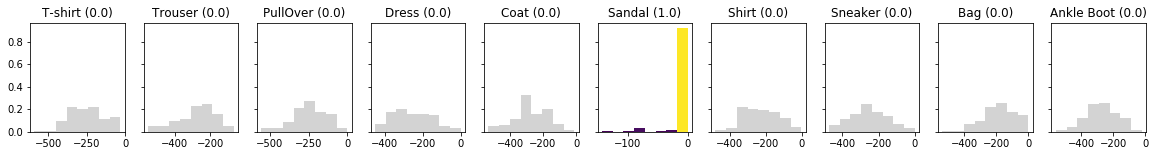

Incorrect :()


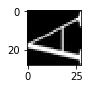

Real:  PullOver


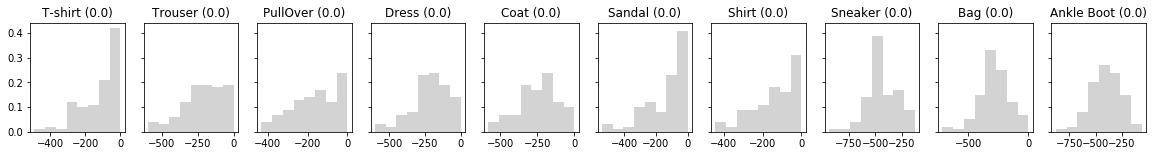

Undecided.


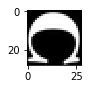

Real:  T-shirt


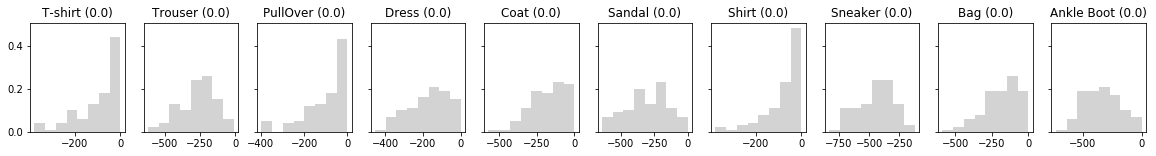

Undecided.


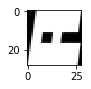

Real:  Coat


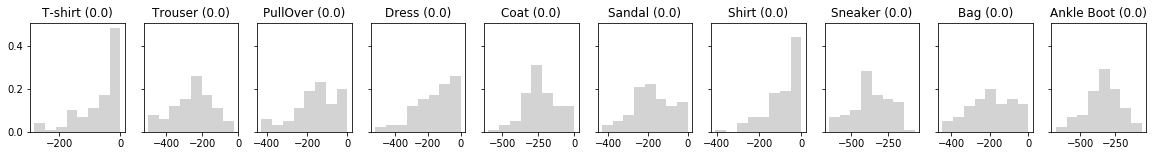

Undecided.


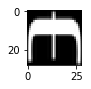

Real:  Sandal


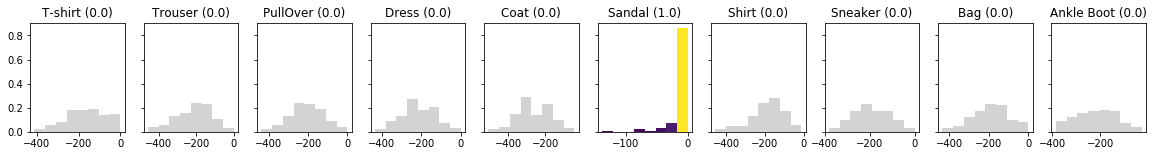

Correct


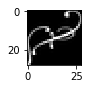

Real:  Coat


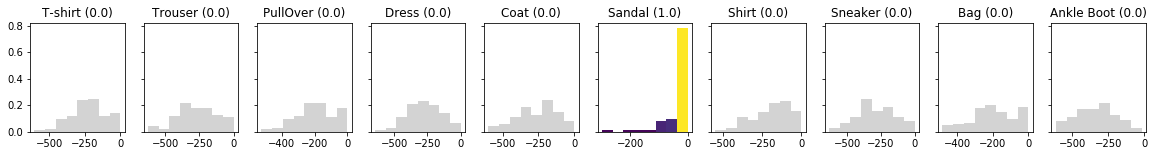

Incorrect :()


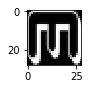

Real:  Trouser


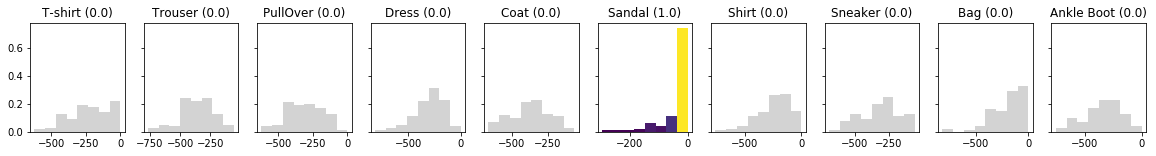

Incorrect :()


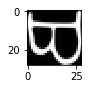

Real:  Shirt


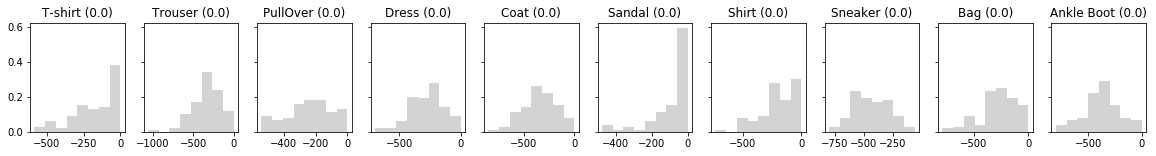

Undecided.


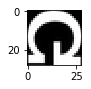

Real:  Ankle Boot


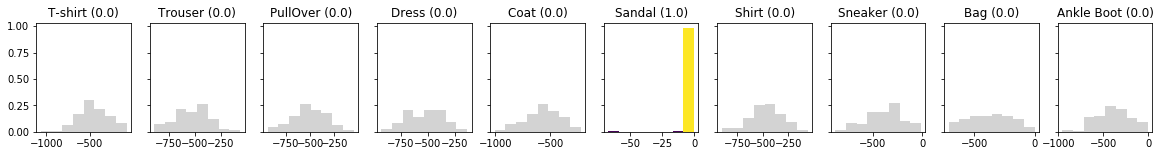

Incorrect :()


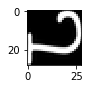

Real:  Shirt


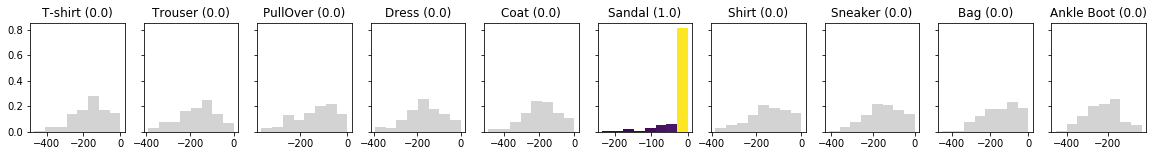

Incorrect :()


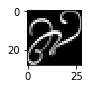

Real:  Sandal


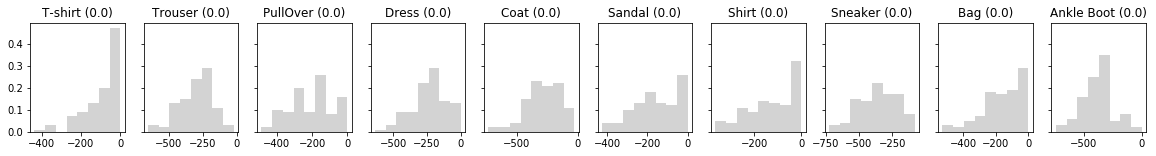

Undecided.


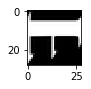

Real:  T-shirt


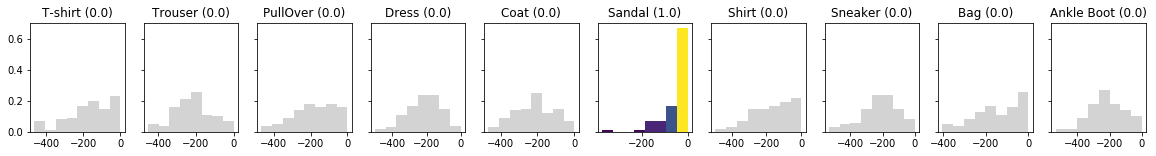

Incorrect :()


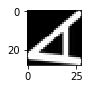

Real:  PullOver


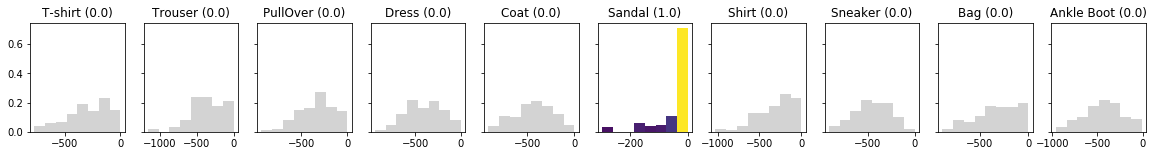

Incorrect :()


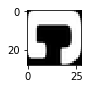

Real:  Dress


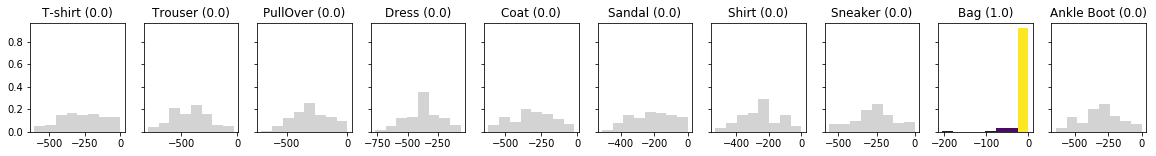

Incorrect :()


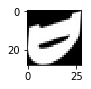

Real:  PullOver


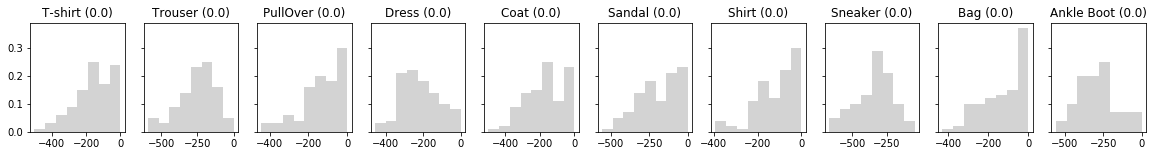

Undecided.


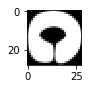

Real:  PullOver


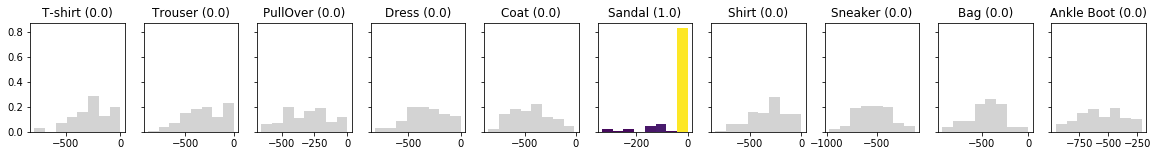

Incorrect :()


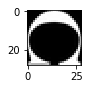

Real:  Dress


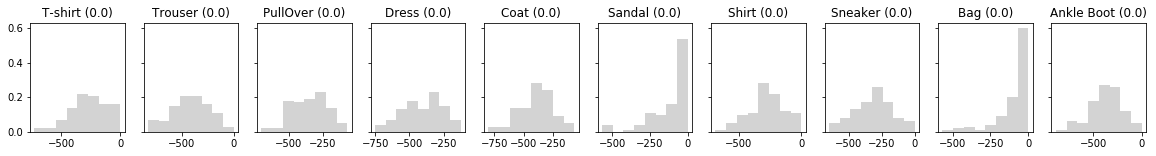

Undecided.


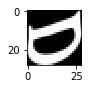

Real:  Sandal


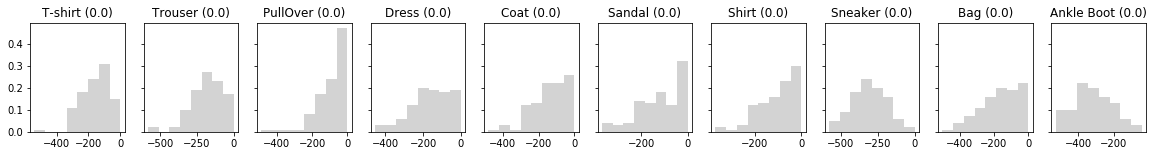

Undecided.


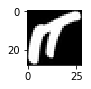

Real:  Coat


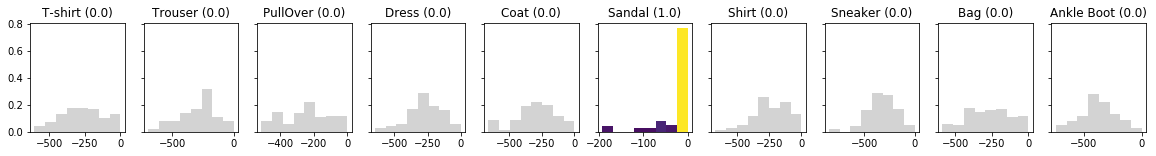

Incorrect :()


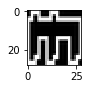

Real:  T-shirt


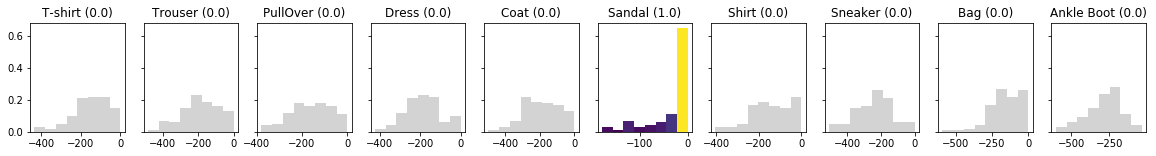

Incorrect :()


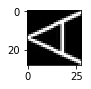

Real:  T-shirt


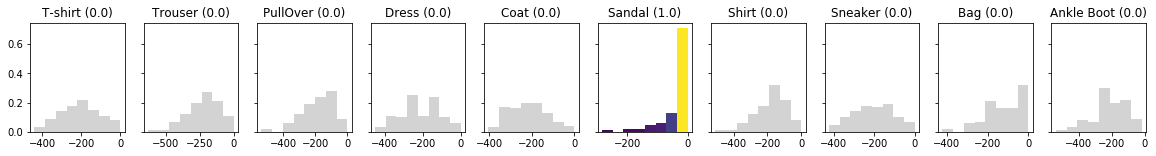

Incorrect :()


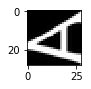

Real:  Sandal


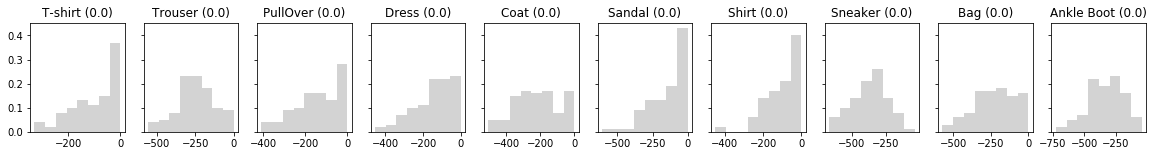

Undecided.


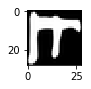

Real:  PullOver


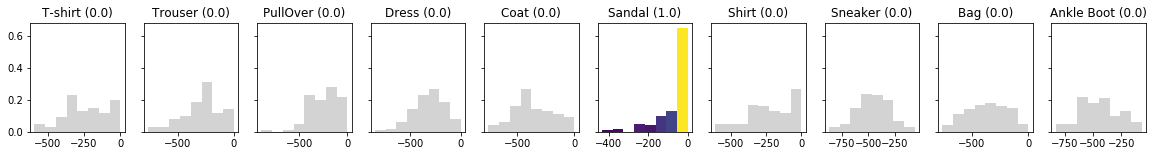

Incorrect :()


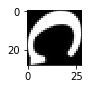

Real:  Shirt


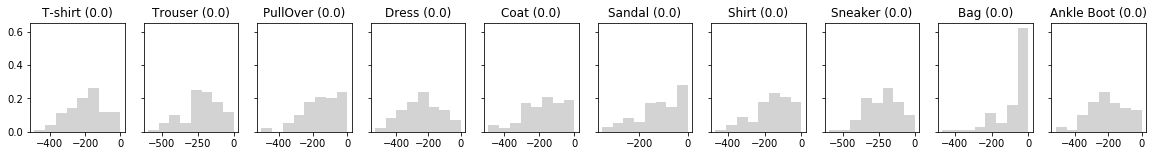

Undecided.


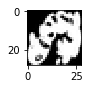

Real:  Shirt


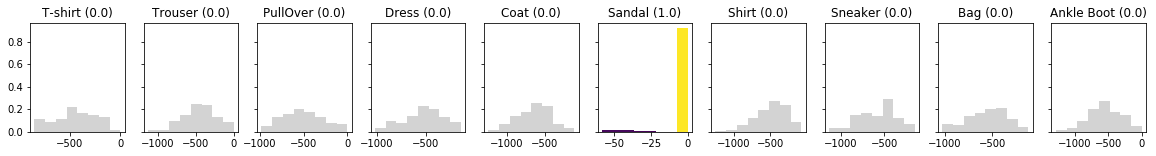

Incorrect :()


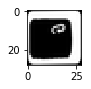

Real:  Sneaker


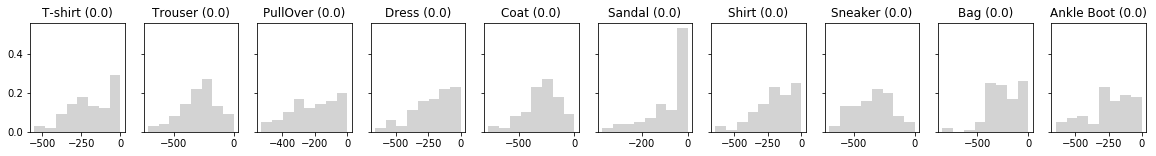

Undecided.


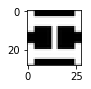

Real:  Sandal


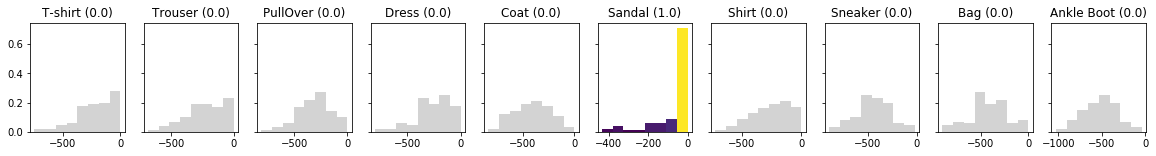

Correct


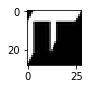

Real:  Trouser


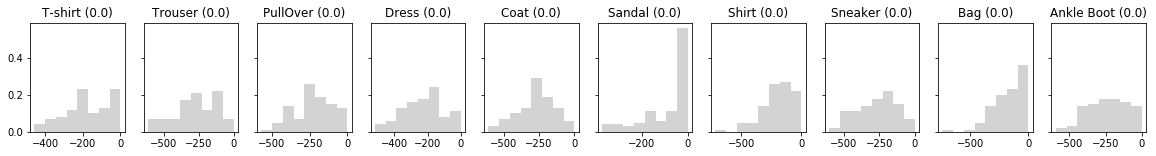

Undecided.


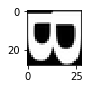

Real:  T-shirt


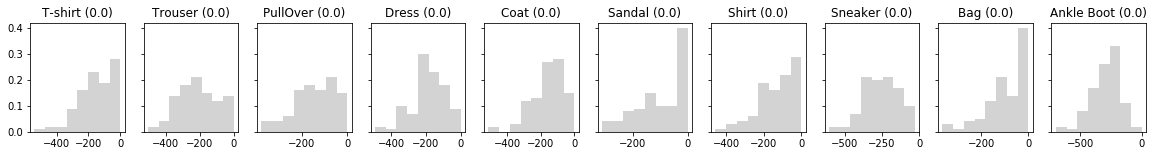

Undecided.


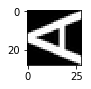

Real:  Sandal


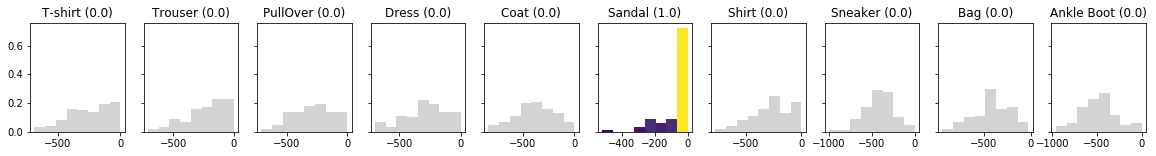

Correct


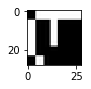

Real:  Coat


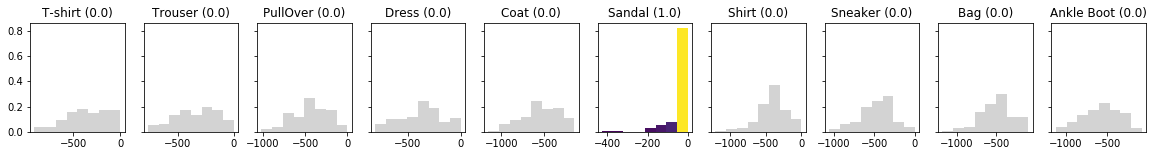

Incorrect :()


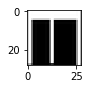

Real:  Ankle Boot


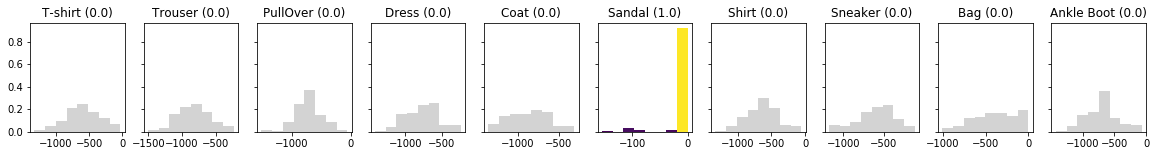

Incorrect :()


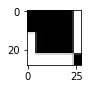

Real:  PullOver


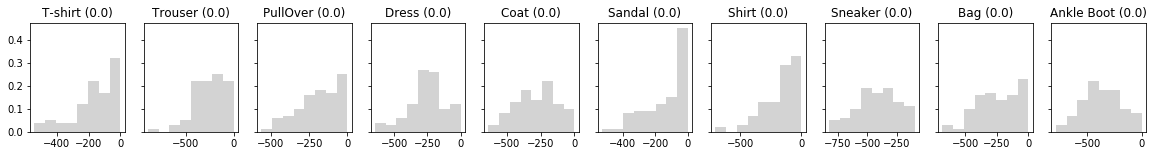

Undecided.


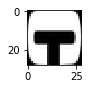

Real:  T-shirt


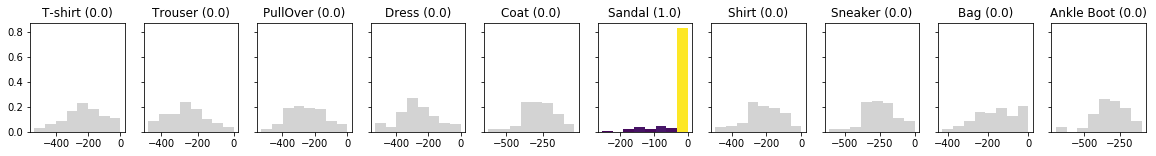

Incorrect :()


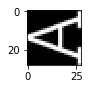

Real:  Coat


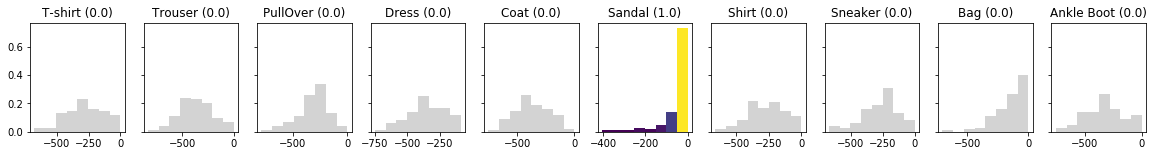

Incorrect :()


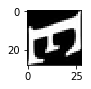

Real:  Sandal


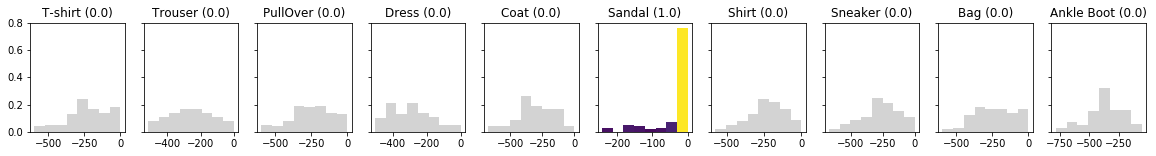

Correct


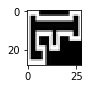

Real:  Trouser


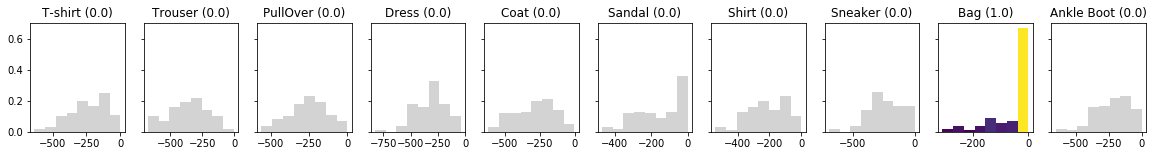

Incorrect :()


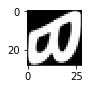

Real:  Ankle Boot


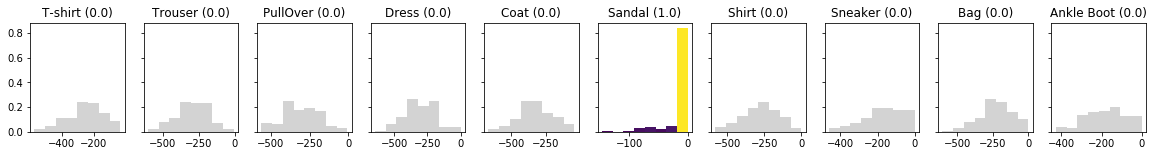

Incorrect :()


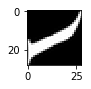

Real:  Shirt


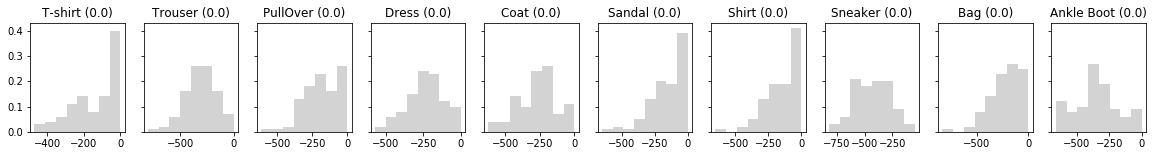

Undecided.


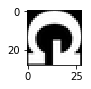

Real:  T-shirt


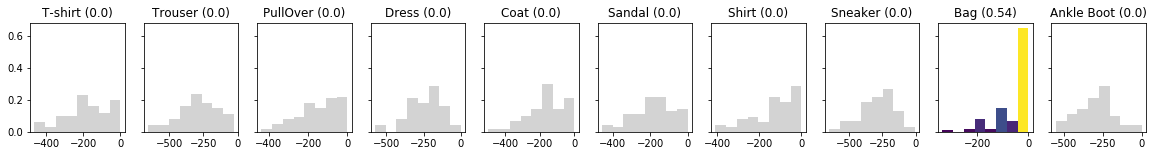

Incorrect :()


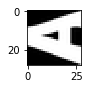

Real:  T-shirt


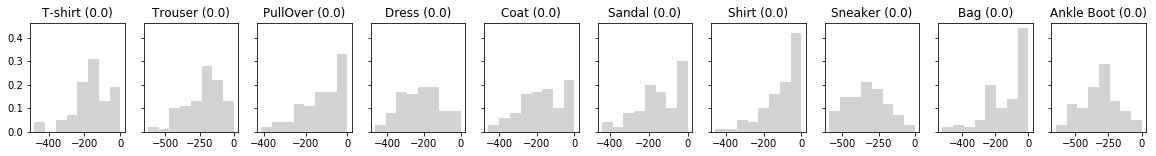

Undecided.


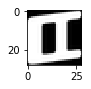

Real:  T-shirt


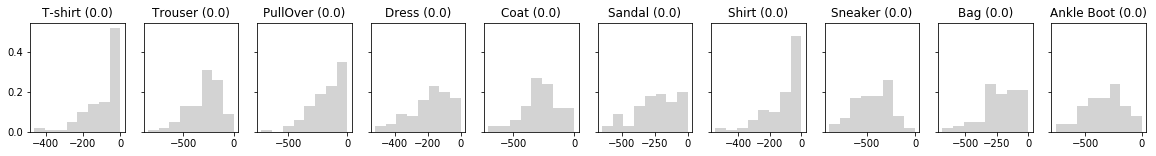

Undecided.


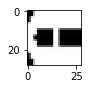

Real:  Sneaker


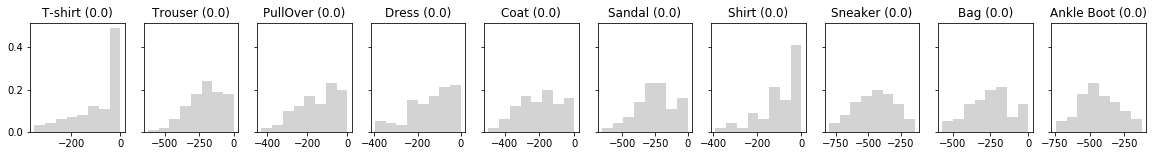

Undecided.


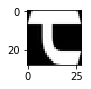

Real:  Dress


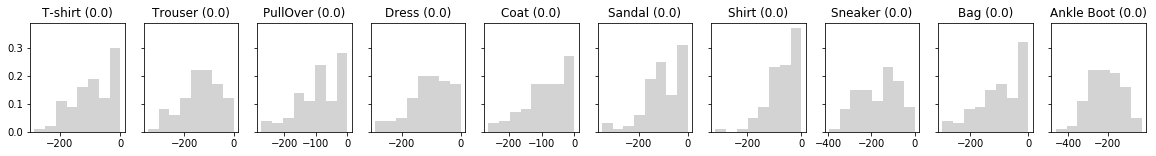

Undecided.


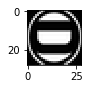

Real:  Ankle Boot


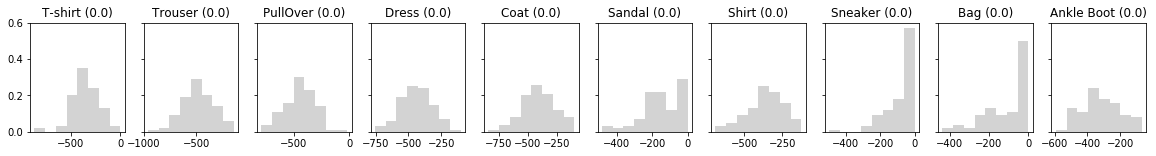

Undecided.


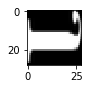

Real:  T-shirt


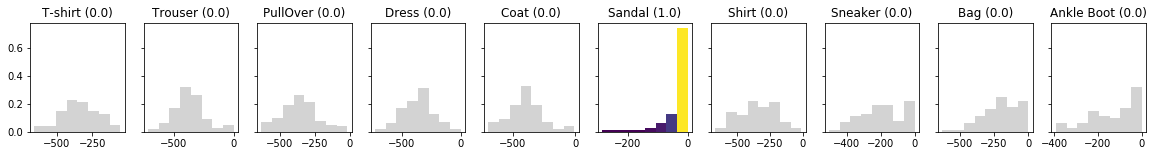

Incorrect :()


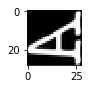

Real:  Dress


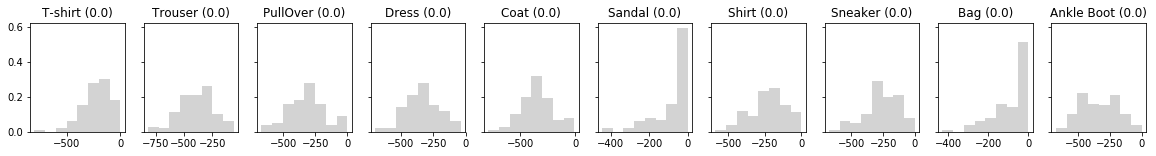

Undecided.


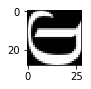

Real:  Sandal


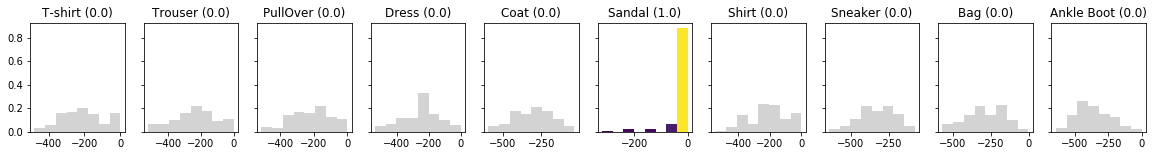

Correct


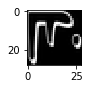

Real:  Sandal


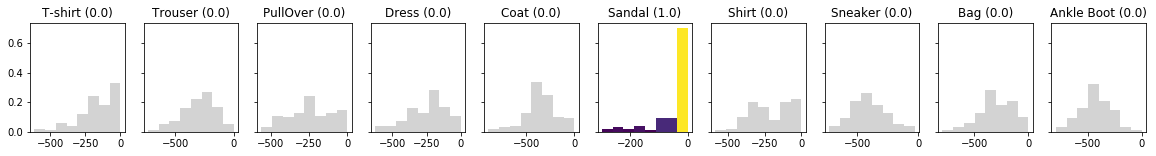

Correct


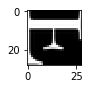

Real:  Trouser


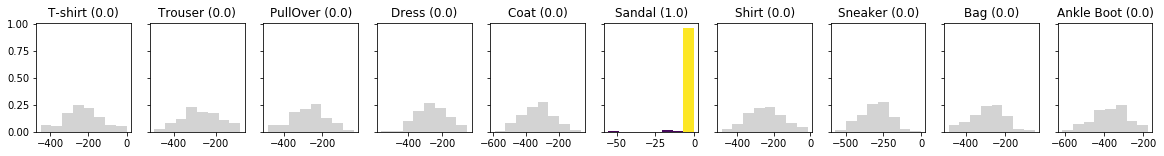

Incorrect :()


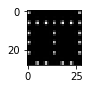

Real:  T-shirt


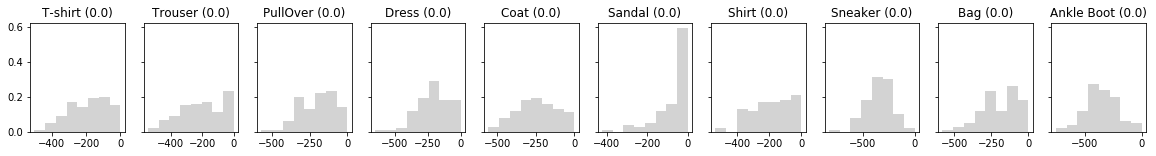

Undecided.


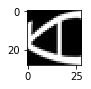

Real:  Dress


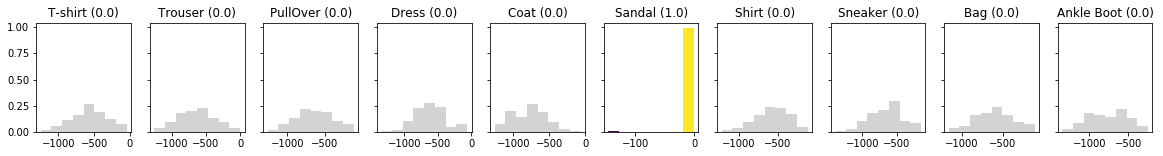

Incorrect :()


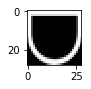

Real:  T-shirt


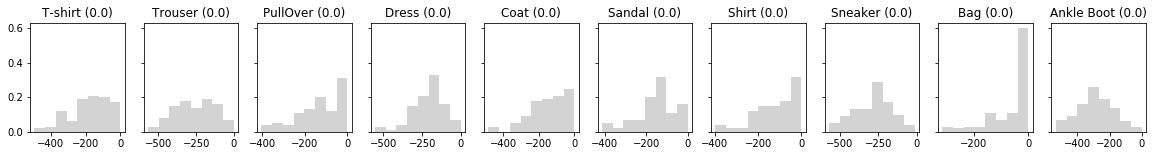

Undecided.


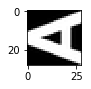

Real:  Dress


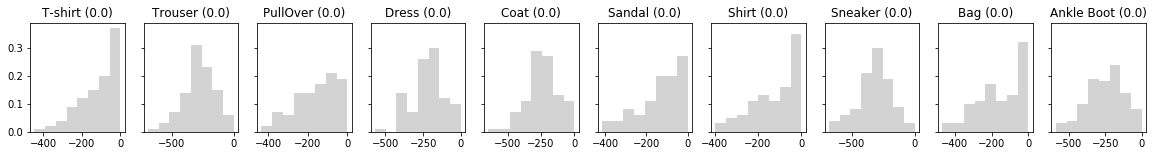

Undecided.


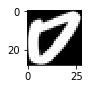

Real:  PullOver


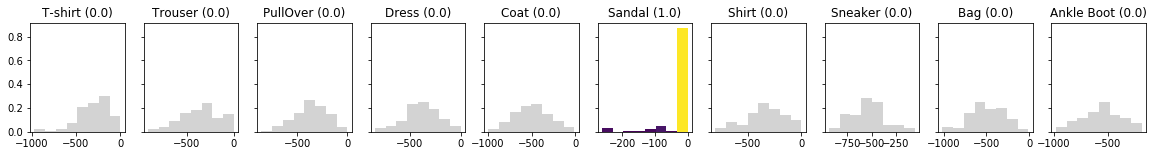

Incorrect :()


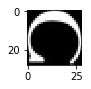

Real:  T-shirt


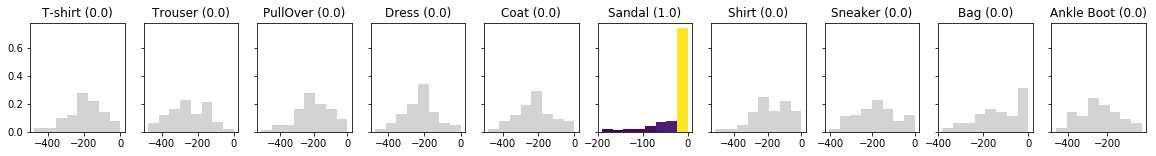

Incorrect :()


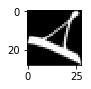

Real:  Shirt


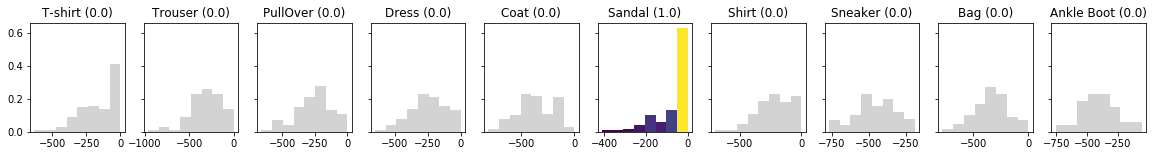

Incorrect :()


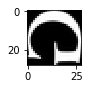

Real:  Sandal


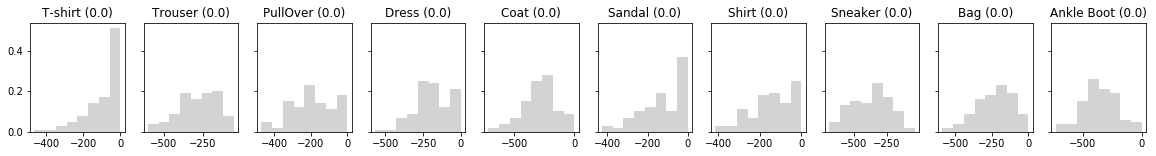

Undecided.


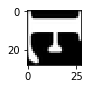

Real:  Dress


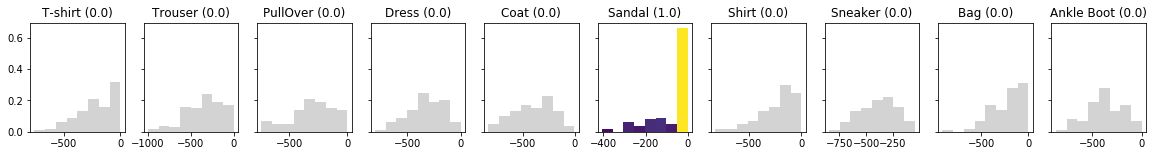

Incorrect :()


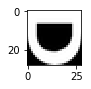

Summary
Total images:  100
Predicted for:  60
Accuracy when predicted:  0.1


(100, 6.0, 60)

In [47]:
test_batch(images_notmnist[:100], labels_notmnist[:100])